# Dimensionality Reduction Methods:
We apply different techniques for dimensionality reduction to visualize and interpret the structure of high-dimensional data.

- **Principal Component Analysis (PCA)**:  
  is a linear technique that reduces dimensionality by projecting data onto the directions that capture the most variance.


- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:  
  is a non-linear technique that preserves local structure by minimizing the Kullback-Leibler (KL) divergence between pairwise similarities in high- and low-dimensional spaces.

- **Linear Discriminant Analysis (LDA)**:  
  is a supervised technique that maximizes class separation by projecting data onto a linear combination of features that best separates different classes.

## Libraries

In [ ]:
## Import Required Libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import math
from collections import Counter

## Synthetic Data

1. **Synthetic Dataset Creation**:
   - We generate a synthetic dataset using the `make_blobs()` function from `sklearn`. The dataset consists of 300 samples, each with 5 features, and is divided into 3 clusters. The true cluster labels are stored in `y`.

2. **Normalization**:
   - After generating the dataset, we apply Min-Max normalization using `MinMaxScaler` to scale the data into the range $[0, 1]$. This normalization ensures that all features have comparable scales, which is especially important for distance-based algorithms like PCA and K-Means.

3. **Data Visualization**:
   - Although the dataset has 5 features, we visualize only the first two dimensions of the data to get an intuitive sense of its structure. The plot shows the spread of data in the first two dimensions, giving us a glimpse of how the clusters are distributed in the original high-dimensional space.

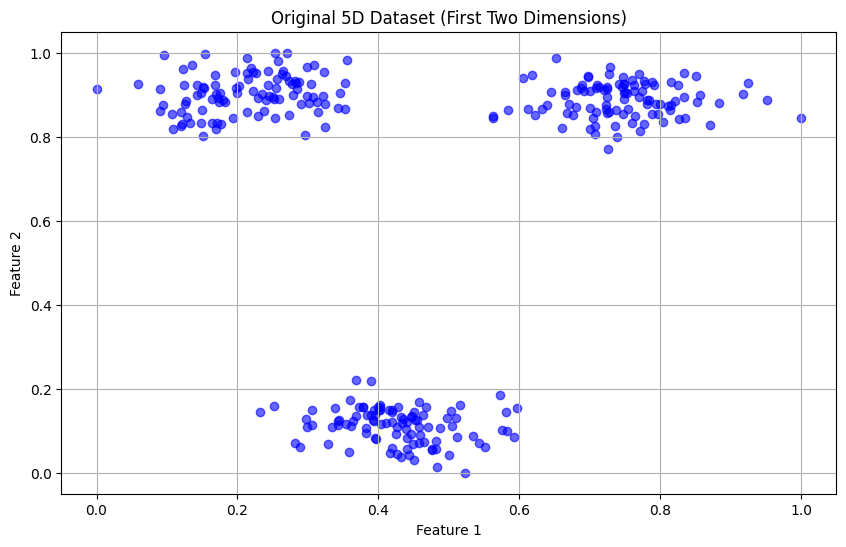

In [ ]:
## Set Random Seed for Reproducibility
torch.manual_seed(42)

## Generate Synthetic Dataset with 5 features
n_samples = 300
n_features = 5
n_clusters = 3
X_numpy, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)
y = torch.tensor(y, dtype=torch.long)

## Normalize the Data: We apply min-max normalization to scale the data to the range [0, 1].
scaler = MinMaxScaler() # You can also use RobustScaler(), MaxAbsScaler(), StandardScaler()
X_normalized_numpy = scaler.fit_transform(X_numpy)
X = torch.tensor(X_normalized_numpy, dtype=torch.float32)

## Visualize the Original Dataset (First Two Dimensions Only)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original 5D Dataset (First Two Dimensions)')
plt.grid(True)
plt.show()

## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) reduces the dimensionality of a dataset by projecting it onto directions (principal components) that capture the most variance. PCA works by first centering the data and then computing the covariance matrix:
$$
\text{Cov}(X) = \frac{1}{n-1} X_{centered}^T X_{centered}
$$
We then perform eigenvalue decomposition:
$$
C v = \lambda v
$$
where $v$ are the eigenvectors (principal components) and $\lambda$ are the corresponding eigenvalues (variance explained). The data is then projected onto the selected components:
$$
X_{pca} = X_{centered} V_k
$$


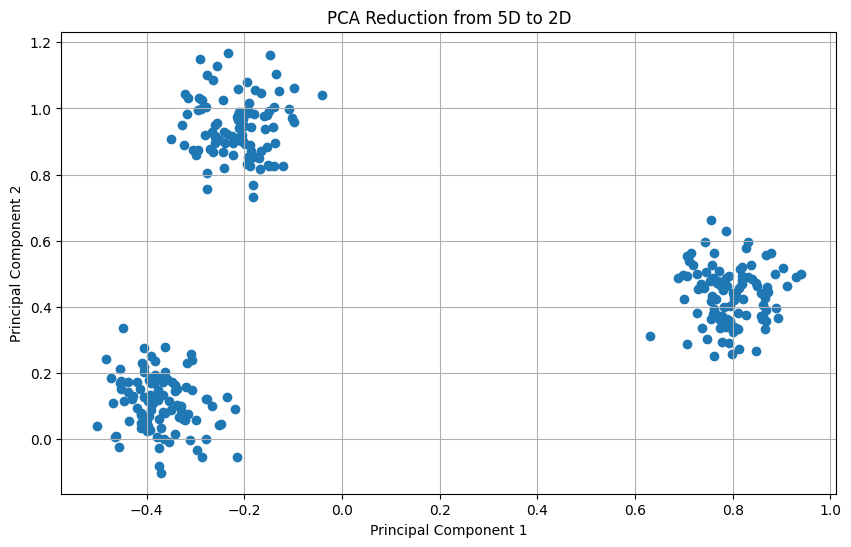

In [ ]:
def pca(X, n_components):
    """
    Perform Principal Component Analysis (PCA) for dimensionality reduction.

    Parameters:
    - X: A tensor of data points (features).
    - n_components: The number of principal components to compute.

    Returns:
    - X_pca: The data projected onto the selected principal components.
    """

    # Center the data by subtracting the mean of each feature from the data points
    X_meaned = X - X.mean(0)

    # Compute the covariance matrix from the centered data
    covariance_matrix = X_meaned.T @ X_meaned / (X.shape[0] - 1)

    # Compute the eigenvalues and eigenvectors of the covariance matrix
    L_complex, V_complex = torch.linalg.eig(covariance_matrix)

    # Extract the real part of the eigenvalues and eigenvectors
    L = L_complex.real
    V = V_complex.real

    # Sort the eigenvalues in descending order and get the corresponding eigenvectors
    idx = L.argsort(descending=True)
    V = V[:, idx]

    # Select the top n_components eigenvectors (principal components)
    principal_components = V[:, :n_components]

    # Project the data onto the selected principal components
    return X @ principal_components


# Apply PCA to reduce from 5 dimensions to 2 dimensions
X_pca = pca(X, 2)

# Plot the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA Reduction from 5D to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique used for visualizing high-dimensional data, especially useful for uncovering clusters.

1. **High-Dimensional Pairwise Similarities**:  
   The similarity between points \( i \) and \( j \) in the high-dimensional space is computed using a Gaussian distribution:
   $$
   P_{ij} = \frac{\exp\left(-\frac{\|x_i - x_j\|^2}{2 \sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\|x_i - x_k\|^2}{2 \sigma_i^2}\right)}
   $$
   where \( \sigma_i \) is chosen to match the desired perplexity.

2. **Low-Dimensional Similarities**:  
   In the low-dimensional space, similarities are modeled using a Student-t distribution:
   $$
   Q_{ij} = \frac{\left(1 + \|y_i - y_j\|^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \|y_k - y_l\|^2\right)^{-1}}
   $$

3. **KL Divergence and Optimization**:  
   t-SNE minimizes the Kullback-Leibler divergence between the high- and low-dimensional distributions:
   $$
   \text{KL}(P \| Q) = \sum_{i} \sum_{j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
   $$
   Gradient descent is used to optimize the low-dimensional representation \( y_i \) to preserve the local structure of the data.


Iteration 0 / 2000, KL Divergence: 0.8650912046432495
Iteration 500 / 2000, KL Divergence: 0.010210884734988213
Iteration 1000 / 2000, KL Divergence: 0.000664173741824925
Iteration 1500 / 2000, KL Divergence: 9.81217235676013e-05


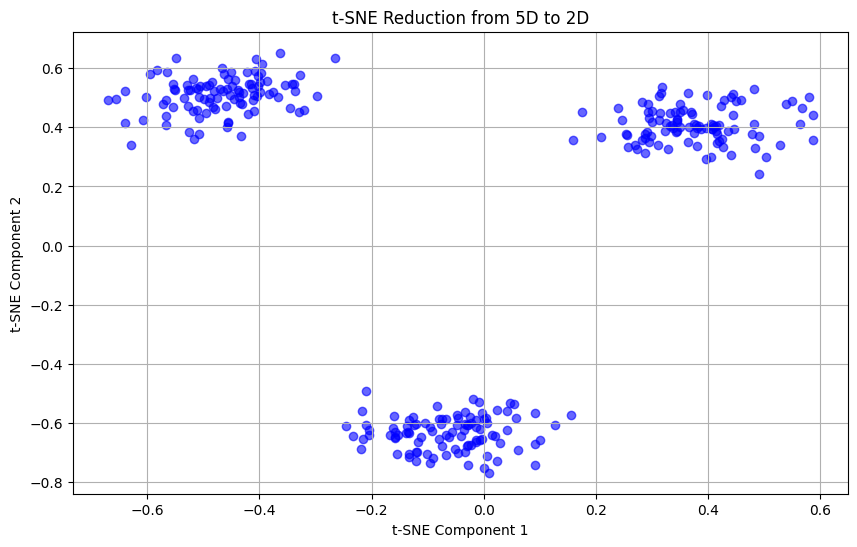

In [ ]:
class TSNE:
    """
    t-Distributed Stochastic Neighbor Embedding (t-SNE) implementation for dimensionality reduction.

    Parameters:
    - n_components: Number of components for low-dimensional projection (default 2).
    - perplexity: Desired perplexity, controls the local-global balance in the similarity matrix.
    - learning_rate: Learning rate for the gradient descent optimization (default 10.0).
    - n_iter: Number of iterations to run the optimization (default 2000).
    - sigma: Bandwidth parameter for the Gaussian kernel in the similarity matrix (default 1.0).

    Methods:
    - pairwise_distances: Compute pairwise distances between all points in the dataset.
    - compute_similarity_matrix: Compute the similarity matrix using a Gaussian kernel.
    - fit_transform: Perform t-SNE for dimensionality reduction and return the low-dimensional embeddings.

    Returns:
    - Y: Low-dimensional representation of the data after t-SNE optimization.
    """

    def __init__(self, n_components=2, perplexity=30.0, learning_rate=10.0, n_iter=2000, sigma=1.0):
        """
        Initialize t-SNE parameters.

        Parameters:
        - n_components: Number of components for low-dimensional projection (default 2).
        - perplexity: Desired perplexity, controls the local-global balance in the similarity matrix.
        - learning_rate: Learning rate for the gradient descent optimization (default 10.0).
        - n_iter: Number of iterations to run the optimization (default 2000).
        - sigma: Bandwidth parameter for the Gaussian kernel in the similarity matrix (default 1.0).
        """
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.sigma = sigma

    def pairwise_distances(self, X):
        """
        Compute pairwise distances between all points in the dataset.

        Parameters:
        - X: Tensor of data points.

        Returns:
        - distances: Tensor of pairwise distances between the points.
        """
        sum_X = torch.sum(X ** 2, dim=1)
        distances = torch.sqrt(F.relu(sum_X.unsqueeze(1) + sum_X.unsqueeze(0) - 2 * torch.matmul(X, X.T)))
        return distances

    def compute_similarity_matrix(self, distances):
        """
        Compute the similarity matrix using a Gaussian kernel.

        Parameters:
        - distances: Pairwise distances between points.

        Returns:
        - sim_matrix: The similarity matrix where entries represent probabilities of proximity.
        """
        sim_matrix = torch.exp(-distances ** 2 / (2 * self.sigma ** 2))
        sim_matrix = sim_matrix / sim_matrix.sum()
        return sim_matrix

    def fit_transform(self, X):
        """
        Perform t-SNE for dimensionality reduction.

        Parameters:
        - X: Tensor of high-dimensional data points.

        Returns:
        - Y: Low-dimensional representation of the data.
        """
        n_samples, n_features = X.shape

        # Step 1: Compute pairwise distances in high-dimensional space
        high_dim_distances = self.pairwise_distances(X)

        # Step 2: Compute similarities in high-dimensional space (P matrix)
        P = self.compute_similarity_matrix(high_dim_distances)

        # Step 3: Initialize random low-dimensional representation
        Y = torch.randn(n_samples, self.n_components, requires_grad=True)  # Low-dimensional embeddings

        # Use stochastic gradient descent (SGD) for optimization
        optimizer = torch.optim.SGD([Y], lr=self.learning_rate)

        # Gradient Descent to minimize KL divergence between high- and low-dimensional similarities
        for i in range(self.n_iter):
            optimizer.zero_grad()  # Clear gradients from the previous iteration

            # Step 4: Compute pairwise distances in low-dimensional space
            low_dim_distances = self.pairwise_distances(Y)

            # Compute similarities in low-dimensional space (Q matrix)
            Q = self.compute_similarity_matrix(low_dim_distances)

            # Step 5: Compute the Kullback-Leibler (KL) divergence between P and Q
            kl_divergence = torch.sum(P * torch.log(P / (Q + 1e-9)))  # KL divergence

            # Backpropagate the gradient of KL divergence
            kl_divergence.backward()

            # Step 6: Update low-dimensional embeddings with gradient descent
            optimizer.step()

            # Print progress every 500 iterations
            if i % 500 == 0:
                print(f"Iteration {i} / {self.n_iter}, KL Divergence: {kl_divergence.item()}")

        return Y  # Return the optimized low-dimensional embeddings


# Apply t-SNE to the 5D dataset
tsne = TSNE(n_components=2, learning_rate=10.0, n_iter=2000)
X_tsne = tsne.fit_transform(X)  # X is your high-dimensional data

# Visualize the t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0].detach().numpy(), X_tsne[:, 1].detach().numpy(), color='blue', alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Reduction from 5D to 2D')
plt.grid(True)
plt.show()


## Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that maximizes the separation between multiple classes by finding a linear combination of features that best separates them. LDA works by computing two scatter matrices:

1. **Within-class scatter matrix** $S_W $:
   $$
   S_W = \sum_{c=1}^{C} \sum_{x_i \in c} (x_i - \mu_c)(x_i - \mu_c)^T
   $$
   where $\mu_c$is the mean of class $c$ and $x_i$ are the samples in that class.

2. **Between-class scatter matrix** $S_B $:
   $$
   S_B = \sum_{c=1}^{C} N_c (\mu_c - \mu)(\mu_c - \mu)^T
   $$
   where $\mu$ is the overall mean of the data, and $N_c$ is the number of samples in class $c$.

We then solve the eigenvalue problem:
$$
S_W^{-1} S_B v = \lambda v
$$
where $v $ are the eigenvectors (linear discriminants) and $\lambda$ are the eigenvalues (separation explained). The data is projected onto these linear discriminants for dimensionality reduction.


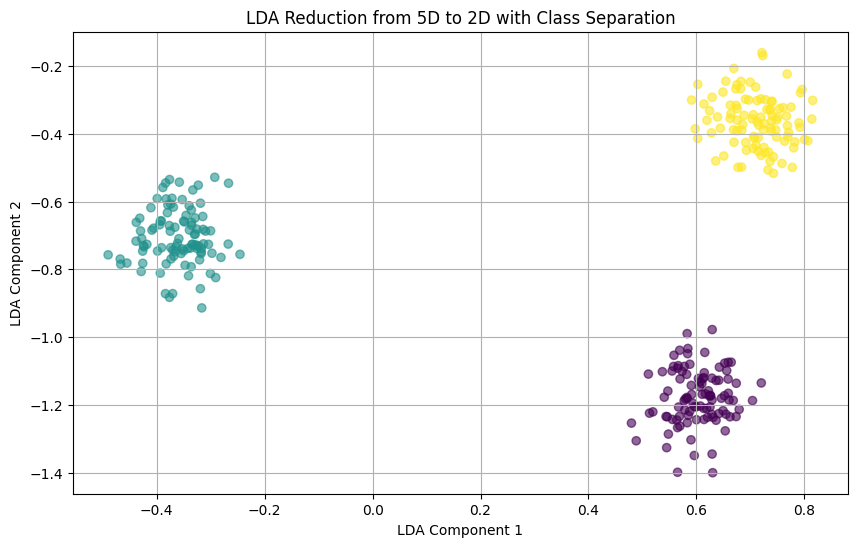

In [ ]:
def lda(X, y, n_components=2):
    """
    Perform Linear Discriminant Analysis (LDA) for dimensionality reduction.

    Parameters:
    - X: A tensor of data points (features).
    - y: The class labels for the data points.
    - n_components: The number of linear discriminants to compute (default 2).

    Returns:
    - X_lda: The data projected onto the new linear discriminants.
    """

    n_features = X.shape[1]
    class_labels = torch.unique(y)

    # Compute the overall mean of the dataset
    mean_overall = torch.mean(X, dim=0)

    # Initialize scatter matrices
    S_W = torch.zeros((n_features, n_features))
    S_B = torch.zeros((n_features, n_features))

    # Compute within-class and between-class scatter matrices
    for label in class_labels:
        X_c = X[y == label]
        mean_c = torch.mean(X_c, dim=0)

        # Within-class scatter matrix
        S_W += (X_c - mean_c).T @ (X_c - mean_c)

        # Between-class scatter matrix
        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).unsqueeze(1)
        S_B += n_c * (mean_diff @ mean_diff.T)

    # Solve the eigenvalue problem for S_W^-1 * S_B
    eigvals, eigvecs = torch.linalg.eig(torch.linalg.inv(S_W) @ S_B)

    # Select the top eigenvectors (linear discriminants)
    eigvals = eigvals.real  # Remove imaginary part if any
    eigvecs = eigvecs.real  # Remove imaginary part
    idx = eigvals.argsort(descending=True)[:n_components]
    W = eigvecs[:, idx]

    # Project the data onto the new linear discriminants
    X_lda = X @ W
    return X_lda

# Apply LDA to the dataset
X_lda = lda(X, y, n_components=2)

# Visualize the LDA result
plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0].detach().numpy(), X_lda[:, 1].detach().numpy(), c=y.numpy(), cmap='viridis', alpha=0.6)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Reduction from 5D to 2D with Class Separation')
plt.grid(True)
plt.show()


# Clustering Methods:
We use clustering algorithms to group the data into clusters after dimensionality reduction.

- **K-Means Clustering**:  
  partitions the data into $k$ clusters by minimizing the within-cluster sum of squares (WCSS)

- **Gaussian Mixture Model (GMM)**:  
  models the data as a mixture of Gaussian distributions, where each data point is assigned to a cluster with a certain probability. The objective is to maximize the likelihood of the data given the mixture of Gaussians.

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**:  
  is a density-based clustering algorithm that groups points closely packed together. It identifies **core points** with at least min_samples neighbors within an $\varepsilon$-radius and labels others as **border points** or **noise**.

- **Gini Impurity & Decision Trees**:  
  recursively split data based on features to maximize class separationand measures the "impurity" of a split. The tree grows by splitting nodes to minimize Gini impurity, stopping based on criteria such as depth or purity.


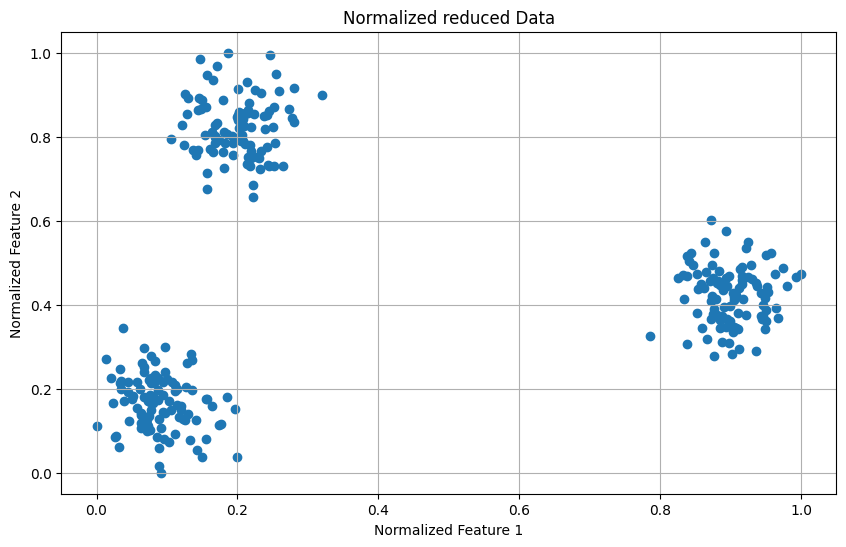

In [ ]:
# Choose the reduced data set
X_reduced = X_pca  # You can also use X_tsne or X_lda

# Normalize the reduced data
X_reduced = scaler.fit_transform(X_reduced.numpy())
X_reduced = torch.tensor(X_reduced, dtype=torch.float32)

# Visualize the GMM clustering result
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title('Normalized reduced Data')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.grid(True)
plt.show()

## K-means Clustering
K-means clustering aims to partition $n$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean. The objective is to minimize the within-cluster sum of squares (WCSS):
$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2
$$


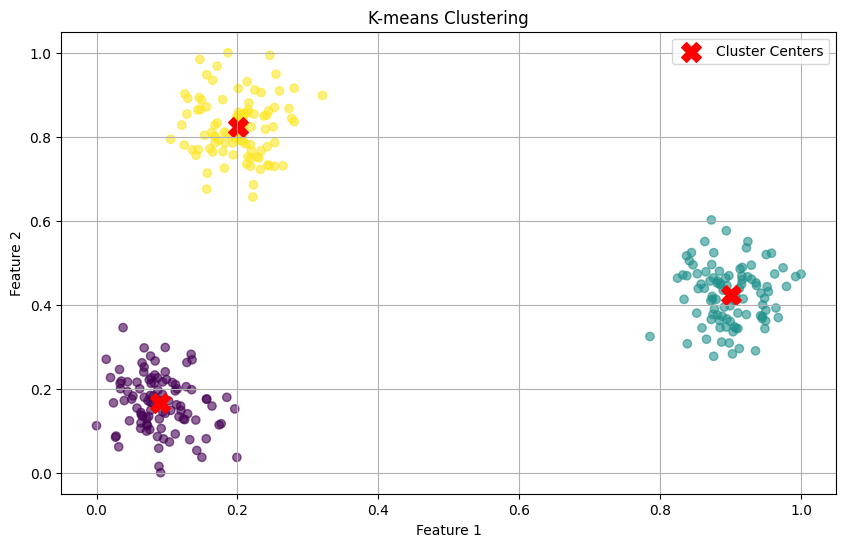

In [ ]:
def k_means_clustering(X, n_clusters, max_iterations=100, tolerance=1e-4):
    """
    Perform K-means clustering on the provided data.

    Parameters:
    - X: A tensor of data points to cluster.
    - n_clusters: The number of clusters to find.
    - max_iterations: The maximum number of iterations to perform (default 100).
    - tolerance: The convergence tolerance (default 1e-4).

    Returns:
    - cluster_centers: The coordinates of the n_clusters cluster centers.
    - cluster_assignments: Index of the cluster each data point is assigned to.
    """

    # Initialize cluster centers randomly
    initial_centers_indices = torch.randperm(X.size(0))[:n_clusters]
    cluster_centers = X[initial_centers_indices]

    for iteration in range(max_iterations):
        # Calculate distances between data points and cluster centers
        distances = torch.cdist(X, cluster_centers)

        # Assign each data point to the closest cluster
        cluster_assignments = torch.argmin(distances, dim=1)

        # Update cluster centers
        new_centers = torch.stack([X[cluster_assignments == k].mean(dim=0) for k in range(n_clusters)])

        # Check for convergence
        if torch.all(torch.abs(new_centers - cluster_centers) < tolerance):
            break

        cluster_centers = new_centers

    return cluster_centers, cluster_assignments

# Perform and Visualize K-means Clustering
cluster_centers, cluster_assignments = k_means_clustering(X_reduced, n_clusters)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_assignments.numpy(), cmap='viridis', alpha=0.6)
plt.scatter(cluster_centers[:, 0].numpy(), cluster_centers[:, 1].numpy(), marker='X', s=200, color='red', label='Cluster Centers')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Gaussian Mixture Model (GMM)
Gaussian Mixture Model (GMM) is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions. The probability density function (PDF) of a Gaussian distribution is given by:
$$
p(x) = \frac{1}{\sqrt{(2 \pi)^d |\Sigma|}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$

The EM algorithm is used to find the parameters that maximize the likelihood of the data.

- **E-step**: Calculate the responsibilities based on the current parameters.
- **M-step**: Update the parameters using the calculated responsibilities.

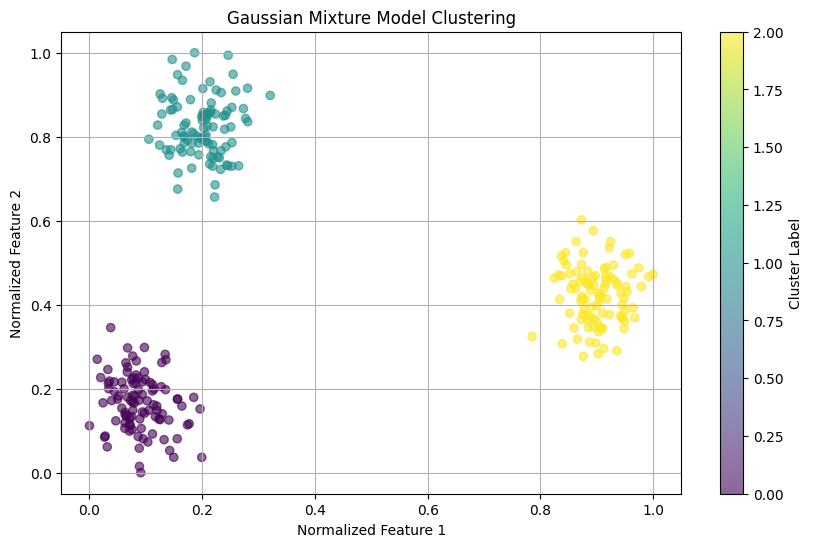

In [ ]:
class GaussianMixtureModel:
    """
    A Gaussian Mixture Model (GMM) implementation for clustering, using the Expectation-Maximization (EM) algorithm.

    Parameters:
    - n_components: The number of Gaussian distributions (clusters) to fit to the data.
    - max_iterations: The maximum number of iterations for the EM algorithm (default 100000).
    - tolerance: The convergence tolerance for the log-likelihood (default 1e-9).

    Methods:
    - initialize_parameters: Randomly initialize the means, covariances, and weights for the GMM.
    - gaussian_pdf: Compute the probability density function of a multivariate Gaussian distribution.
    - fit: Fit the GMM to the provided data using the EM algorithm.
    - predict: Predict the cluster assignments for new data based on the fitted GMM.

    Returns:
    - Means: The means of the fitted Gaussian components.
    - Covariances: The covariance matrices of the fitted Gaussian components.
    - Weights: The weights (mixing coefficients) for each Gaussian component.
    - Cluster Assignments: The predicted cluster for each data point.
    """

    def __init__(self, n_components, max_iterations=100000, tolerance=1e-9):
        """
        Initialize Gaussian Mixture Model (GMM) parameters.

        Parameters:
        - n_components: The number of Gaussian distributions (clusters) to fit to the data.
        - max_iterations: The maximum number of iterations for the Expectation-Maximization algorithm (default 100000).
        - tolerance: The convergence tolerance for the log-likelihood (default 1e-9).
        """
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def initialize_parameters(self, X):
        """
        Initialize the parameters for the GMM.

        Parameters:
        - X: Tensor of data points.

        Returns:
        - Initializes the means, covariances, and weights for the GMM.
        """

        n_samples, n_features = X.shape
        # Randomly select initial means from the data points
        self.means = X[torch.randperm(n_samples)[:self.n_components]]

        # Initialize covariances as identity matrices
        self.covariances = torch.stack([torch.eye(n_features) for _ in range(self.n_components)])

        # Initialize weights equally
        self.weights = torch.ones(self.n_components) / self.n_components

    def gaussian_pdf(self, X, mean, covariance):
        """
        Compute the multivariate Gaussian probability density function (PDF).

        Parameters:
        - X: Tensor of data points.
        - mean: The mean vector of the Gaussian distribution.
        - covariance: The covariance matrix of the Gaussian distribution.

        Returns:
        - The probability density for each data point.
        """

        n_features = X.shape[1]
        # Compute the difference between data points and the mean
        diff = X - mean

        # Compute the inverse of the covariance matrix (with small value added for numerical stability)
        inv_cov = torch.linalg.inv(covariance)

        # Compute the exponential term of the Gaussian PDF
        exp_term = torch.exp(-0.5 * torch.sum(diff @ inv_cov * diff, dim=1))

        # Compute the normalization coefficient
        coef = 1 / (math.sqrt((2 * math.pi) ** n_features * torch.det(covariance)))

        return coef * exp_term

    def fit(self, X):
        """
        Fit the Gaussian Mixture Model to the data using the Expectation-Maximization (EM) algorithm.

        Parameters:
        - X: Tensor of data points.

        Returns:
        - Updates the means, covariances, and weights of the GMM to best fit the data.
        """

        n_samples, _ = X.shape
        self.initialize_parameters(X)
        log_likelihoods = []

        for iteration in range(self.max_iterations):
            # E-step: calculate the responsibilities (probability of each point belonging to each Gaussian)
            responsibilities = torch.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])

            # Normalize responsibilities (so each row sums to 1)
            responsibilities = responsibilities / responsibilities.sum(dim=1, keepdim=True)

            # M-step: update the parameters based on the responsibilities
            N_k = responsibilities.sum(dim=0)  # Effective number of points assigned to each component

            # Update weights
            self.weights = N_k / n_samples

            # Update means
            self.means = torch.stack([torch.sum(responsibilities[:, k].unsqueeze(1) * X, dim=0) / N_k[k] for k in range(self.n_components)])

            # Update covariances
            self.covariances = torch.stack([
                (responsibilities[:, k].unsqueeze(1) * (X - self.means[k])).T @ (X - self.means[k]) / N_k[k]
                for k in range(self.n_components)
            ])

            # Compute the log likelihood for convergence check
            weighted_pdf = torch.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                weighted_pdf[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])

            # Total log likelihood
            log_likelihood = torch.sum(torch.log(weighted_pdf.sum(dim=1)))
            log_likelihoods.append(log_likelihood)

            # Check for convergence
            if iteration > 0 and torch.abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tolerance:
                break

    def predict(self, X):
        """
        Predict the cluster assignments for each data point based on the fitted GMM.

        Parameters:
        - X: Tensor of data points to cluster.

        Returns:
        - The predicted cluster assignment for each data point.
        """

        # Compute responsibilities for the data
        responsibilities = torch.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self.gaussian_pdf(X, self.means[k], self.covariances[k])

        # Assign each point to the cluster with the highest responsibility
        return torch.argmax(responsibilities, dim=1)


# Perform and Visualize GMM Clustering
gmm = GaussianMixtureModel(n_components=n_clusters)
gmm.fit(X_reduced)
gmm_clusters = gmm.predict(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=gmm_clusters.numpy(), cmap='viridis', alpha=0.6)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a clustering algorithm that groups together points that are closely packed, marking points that lie alone in low-density regions as noise. It does not assume any predefined distribution and can discover clusters of arbitrary shapes.

The epsilon-neighborhood of a point \( x_i \) is defined as:
$$
N_\varepsilon(x_i) = \{ x_j \in X \mid \|x_i - x_j\| \leq \varepsilon \}
$$

A point \$x_i$ is classified as:
- A **core point** if the number of points in its neighborhood is at least the minimum number of samples:
$$
|N_\varepsilon(x_i)| \geq min_\textrm{samples}
$$
- A **border point** if it is within the neighborhood of a core point but does not have enough neighbors to be a core point.
- A **noise point** if it is not reachable from any core point.

DBSCAN uses a density-based approach where:
- **Core Points** are the central points of dense clusters.
- **Border Points** connect to core points but do not have enough neighbors to be core points.
- **Noise Points** are outliers and are not part of any cluster.


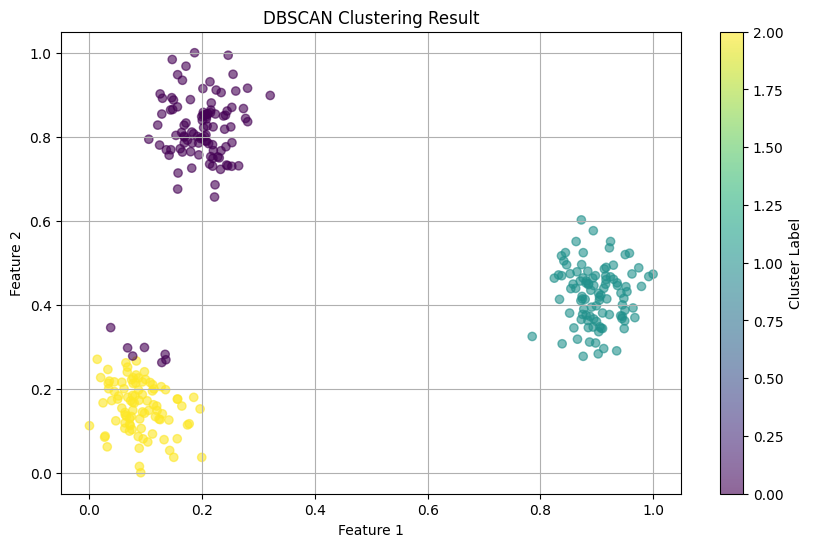

In [ ]:
class DBSCAN:
    """
    Density-Based Spatial Clustering of Applications with Noise (DBSCAN) for clustering.

    Parameters:
    - eps: The maximum distance between two samples for them to be considered as in the same neighborhood (default 0.5).
    - min_samples: The number of samples in a neighborhood for a point to be considered a core point (default 5).

    Methods:
    - fit_predict: Performs DBSCAN clustering on the dataset and returns the cluster assignments.

    Returns:
    - labels: Cluster labels for each data point (-1 for noise).
    """

    def __init__(self, eps=0.5, min_samples=5):
        """
        Initialize DBSCAN parameters.

        Parameters:
        - eps: The maximum distance between two samples for them to be considered neighbors.
        - min_samples: The number of samples in a neighborhood for a point to be considered a core point.
        """
        self.eps = eps
        self.min_samples = min_samples

    def fit_predict(self, X):
        """
        Perform DBSCAN clustering on the dataset.

        Parameters:
        - X: Tensor of data points (features).

        Returns:
        - labels: Cluster labels for each data point (-1 for noise).
        """
        # Convert the data to a numpy array
        X_np = X.numpy()

        # Find the nearest neighbors for each point
        neighbors = NearestNeighbors(radius=self.eps).fit(X_np)
        distances, indices = neighbors.radius_neighbors(X_np)

        # Initialize labels as -1 for noise
        labels = torch.full((X.shape[0],), -1, dtype=torch.long)
        cluster_id = 0

        # Iterate over each point
        for point_idx in range(X.shape[0]):
            if labels[point_idx] != -1:  # Skip if already labeled
                continue

            # Get neighbors within the eps radius
            neighbors_within_eps = indices[point_idx]

            if len(neighbors_within_eps) < self.min_samples:  # Mark as noise if not enough neighbors
                continue

            # Start a new cluster
            labels[point_idx] = cluster_id
            stack = list(neighbors_within_eps)

            # Expand the cluster
            while stack:
                neighbor_idx = stack.pop()

                if labels[neighbor_idx] == -1:  # If the point is labeled as noise, make it part of the cluster
                    labels[neighbor_idx] = cluster_id

                if labels[neighbor_idx] != -1:  # If already labeled, skip
                    continue

                # Add the point to the cluster
                labels[neighbor_idx] = cluster_id

                # Expand the cluster if the neighbor has enough points within eps
                neighbors_of_neighbor = indices[neighbor_idx]
                if len(neighbors_of_neighbor) >= self.min_samples:
                    stack.extend(neighbors_of_neighbor)

            cluster_id += 1  # Move to the next cluster

        return labels

# Perform and Visualize DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=dbscan_labels.numpy(), cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering Result')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

## Random Forest and Gradient Boosting

#### **Decision Trees**:
The core component of both **Random Forest** and **Gradient Boosting** is the decision tree. Decision trees make splits based on feature values to minimize impurity, measured by Gini impurity.

##### **Gini Impurity**:
Gini impurity measures the chance of incorrect classification:
$$
G = 1 - \sum_{i=1}^{C} p_i^2
$$
where $p_i$ is the proportion of samples in class $i$.

##### **Splitting a Node**:
For a feature $f$ and threshold $t$, the dataset is split into two subsets:
- **Left Subset**: Samples where feature $f < t$
- **Right Subset**: Samples where feature $f \geq t$

The Gini impurity for the split is:
$$
G_{\text{split}} = \frac{n_{\text{left}}}{n} G_{\text{left}} + \frac{n_{\text{right}}}{n} G_{\text{right}}
$$
where $n$ is the total number of samples.

---

#### **Random Forest**
**Random Forest** is an ensemble method that builds multiple decision trees independently through a process called **bagging**.

##### **Bagging**:
Each tree is trained on a random subset of the data (with replacement). Predictions are made by majority voting among all the trees to enhance robustness and reduce variance.

##### **Stopping Criteria**:
Splitting stops when:
1. The node reaches a maximum depth.
2. The Gini impurity is minimized (pure node).
3. A minimum number of samples is reached in a node.

---

#### **Gradient Boosting**
**Gradient Boosting** is another ensemble method that builds trees sequentially, with each tree learning from the errors made by the previous ones.

##### **Sequential Learning**:
Each new tree is trained on the residual errors of the combined predictions from all previous trees. This allows the model to focus on difficult cases and improve overall accuracy.

##### **Learning Rate**:
In Gradient Boosting, the contribution of each tree is scaled by a learning rate, controlling the impact of each tree on the final prediction.

##### **Stopping Criteria**:
The process stops when:
1. The maximum number of trees is reached.
2. The improvement in predictions falls below a certain threshold.



In [ ]:
class DecisionTree:
    """
    A simple Decision Tree implementation for classification.

    Methods:
    - fit: Train the decision tree using a subset of the data.
    - predict: Predict the class label for new data points.
    """

    def __init__(self, max_depth=None):
        """
        Initialize the Decision Tree.

        Parameters:
        - max_depth: The maximum depth of the tree (default is None, which means unlimited depth).
        """
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Train the Decision Tree.

        Parameters:
        - X: Training feature data.
        - y: Training labels.
        """
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """
        Predict the class label for new data points.

        Parameters:
        - X: Test feature data.

        Returns:
        - Predicted class labels.
        """
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _build_tree(self, X, y, depth):
        # If the tree has reached max depth or there's only one class, return the most common class
        if depth == self.max_depth or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        # Find the best split
        feature, threshold = self._best_split(X, y)

        # Split the data
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold

        if sum(left_indices) == 0 or sum(right_indices) == 0:
            return Counter(y).most_common(1)[0][0]

        # Create the tree recursively
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {"feature": feature, "threshold": threshold, "left": left_subtree, "right": right_subtree}

    def _best_split(self, X, y):
        # Find the best feature and threshold to split the data
        best_feature, best_threshold = 0, 0
        best_gini = float("inf")

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gini = self._gini_impurity(X[:, feature], y, threshold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, feature_values, y, threshold):
        # Calculate Gini impurity for a given split
        left_indices = feature_values < threshold
        right_indices = feature_values >= threshold

        if sum(left_indices) == 0 or sum(right_indices) == 0:
            # If either side has no points, return max Gini impurity (1) to avoid dividing by zero
            return 1

        left_gini = 1 - sum((sum(left_indices & (y == class_label)) / sum(left_indices)) ** 2 for class_label in set(y))
        right_gini = 1 - sum((sum(right_indices & (y == class_label)) / sum(right_indices)) ** 2 for class_label in set(y))

        total_gini = (sum(left_indices) * left_gini + sum(right_indices) * right_gini) / len(y)
        return total_gini

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree["feature"]] < tree["threshold"]:
                return self._predict_sample(sample, tree["left"])
            else:
                return self._predict_sample(sample, tree["right"])
        else:
            return tree

### Random Forest

Random Forest Accuracy: 98.89%


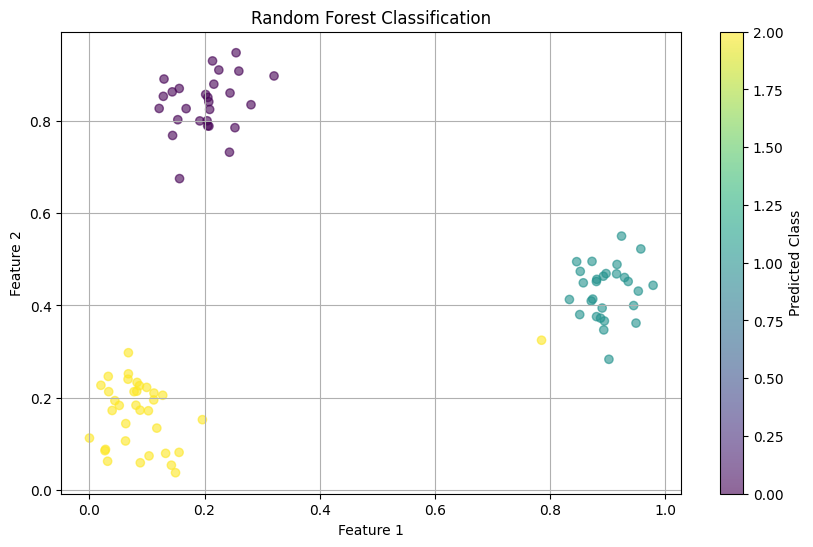

In [ ]:
class RandomForestModel:
    """
    A Random Forest implementation for classification using multiple decision trees.

    Parameters:
    - n_estimators: The number of decision trees in the forest.
    - max_depth: The maximum depth of each decision tree.

    Methods:
    - fit: Train the Random Forest using the training data.
    - predict: Predict the class labels for new data.

    Returns:
    - The predicted class labels for each data point.
    """

    def __init__(self, n_estimators=10, max_depth=None):
        """
        Initialize Random Forest model parameters.

        Parameters:
        - n_estimators: The number of decision trees in the forest (default 10).
        - max_depth: The maximum depth of each tree (default None).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        """
        Train the Random Forest model.

        Parameters:
        - X: Training feature data.
        - y: Training labels.
        """
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            # Bootstrap sample (random sampling with replacement)
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predict the class labels for test data.

        Parameters:
        - X: Test feature data.

        Returns:
        - Predicted class labels for each data point in X.
        """
        # Get predictions from each tree
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # Use majority vote to determine the final prediction
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_predictions)


# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X_reduced.numpy(), y.numpy(), test_size=0.3, random_state=42)

# Train and predict using custom Random Forest
rf_model = RandomForestModel(n_estimators=10, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.title('Random Forest Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.grid(True)
plt.show()


### Gradient Boosting Model

Gradient Boosting Accuracy: 98.89%


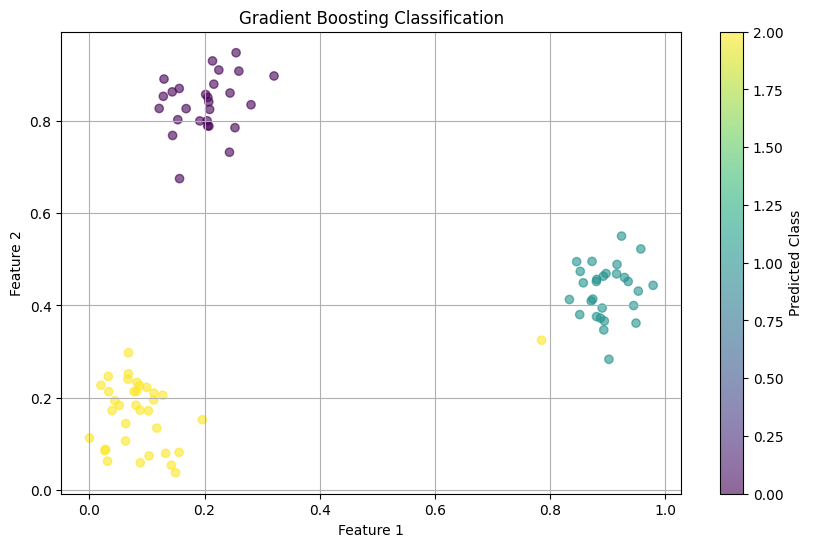

In [ ]:
class GradientBoostingModel:
    """
    A Gradient Boosting implementation for classification using sequential decision trees.

    Parameters:
    - n_estimators: The number of decision trees to be trained sequentially.
    - learning_rate: The rate at which the model corrects the errors from previous trees.
    - max_depth: The maximum depth of each decision tree.

    Methods:
    - fit: Train the Gradient Boosting model using the training data.
    - predict: Predict the class labels for new data.

    Returns:
    - The predicted class labels for each data point.
    """

    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=None):
        """
        Initialize Gradient Boosting model parameters.

        Parameters:
        - n_estimators: The number of trees (default 10).
        - learning_rate: The step size for updates (default 0.1).
        - max_depth: The maximum depth of each tree (default None).
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_pred = None

    def fit(self, X, y):
        """
        Train the Gradient Boosting model.

        Parameters:
        - X: Training feature data.
        - y: Training labels.
        """
        # Initialize predictions to the mean of the target (classification) or regression value
        self.initial_pred = np.mean(y)
        residuals = y - self.initial_pred

        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)  # Fit tree on residuals
            self.trees.append(tree)

            # Update residuals (error)
            predictions = tree.predict(X)
            residuals -= self.learning_rate * predictions

    def predict(self, X):
        """
        Predict the class labels for new data points.

        Parameters:
        - X: Test feature data.

        Returns:
        - Predicted class labels for each data point in X.
        """
        # Start with the initial prediction
        predictions = np.full(X.shape[0], self.initial_pred)

        # Add predictions from each tree, scaled by the learning rate
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        return np.round(predictions).astype(int)


# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X_reduced.numpy(), y.numpy(), test_size=0.3, random_state=42)

# Train and predict using Gradient Boosting
gb_model = GradientBoostingModel(n_estimators=10, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Accuracy: {accuracy * 100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.title('Gradient Boosting Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Class')
plt.grid(True)
plt.show()


# Neural Network Architectures:
We utilize different neural network models to learn complex patterns from data and solve various tasks.

- **Feedforward Neural Network (FNN)**:  
  is the most basic type of neural network where information flows in one direction—from input to output—without any cycles or feedback. It is effective for simple regression and classification tasks.

- **Recurrent Neural Network (RNN)**:  
  is designed for sequence data, where the output depends on the previous inputs. It uses loops to allow information to persist, making it suitable for time series, text, and sequential data analysis.

- **Convolutional Neural Network (CNN)**:  
  is a specialized network for processing grid-like data, such as images. It uses convolutional layers to automatically learn spatial hierarchies of features, making it highly effective for image recognition and classification.

- **Quantum Neural Network (QNN)**:  
  combines principles from quantum computing with neural networks. It leverages quantum mechanics for more complex data representations and can be beneficial in solving problems with high computational complexity.

## Feedforward Neural Network for Classification (FFNN)

A **Feedforward Neural Network (FFNN)** is a simple neural network where data moves in one direction, from input to output, through hidden layers.

### Problem Description:
We use an FFNN to classify **Iris flowers** based on features:
- Sepal length, Sepal width
- Petal length, Petal width

The task is to predict one of 3 species: Setosa, Versicolor, or Virginica.

### FFNN:
1. **Linear Combination** at each layer:
   $$ z^{(l)} = W^{(l)} x^{(l-1)} + b^{(l)} $$
2. **Activation Function** introduces non-linearity:
   $$ x^{(l)} = f(z^{(l)}) $$
3. **Output Layer** produces class probabilities using softmax:
   $$ y = \text{softmax}(W^{(L)} x^{(L-1)} + b^{(L)}) $$

### Steps:
1. Load and preprocess the Iris dataset.
2. Define the FFNN with hidden layers and activation functions.
3. Train the model using cross-entropy loss and backpropagation.
4. Test the model on the test set and evaluate accuracy.


Epoch [10/100], Loss: 0.7783
Epoch [20/100], Loss: 0.5399
Epoch [30/100], Loss: 0.3921
Epoch [40/100], Loss: 0.2934
Epoch [50/100], Loss: 0.2166
Epoch [60/100], Loss: 0.1639
Epoch [70/100], Loss: 0.1284
Epoch [80/100], Loss: 0.1050
Epoch [90/100], Loss: 0.0902
Epoch [100/100], Loss: 0.0800
Accuracy: 96.67%


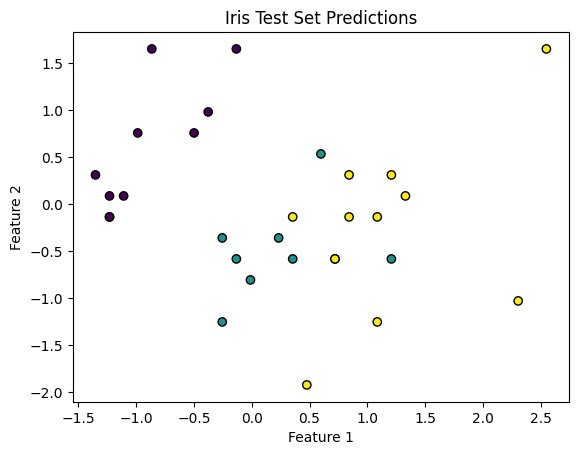

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the Feedforward Neural Network architecture
class FeedforwardNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model: nn.Module,
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int = 100) -> None:

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Function to test the model
def test_model(model: nn.Module, X_test: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
    return predicted

# Main execution flow
if __name__ == "__main__":
    # Load and prepare the Iris dataset
    iris = load_iris()
    X = iris.data
    y = iris.target

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the dataset (mean=0, std=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Define model parameters
    input_size = X_train.shape[1]  # 4 features
    hidden_size = 10
    output_size = len(np.unique(y))  # 3 classes

    # Initialize model, loss function, and optimizer
    model = FeedforwardNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    train_model(model, X_train, y_train, criterion, optimizer, epochs=100)

    # Test the model
    y_pred = test_model(model, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Plotting the results
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k')
    plt.title('Iris Test Set Predictions')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

## Recurrent Neural Network for Prediction (RNN)

An **RNN** processes sequential data by maintaining a hidden state that captures information from previous time steps. This is ideal for tasks like **time-series forecasting**.

### Problem Description:
We use an RNN to predict future values of a **sine wave** based on past observations.

### RNN:
1. **Hidden State Update** at each time step:
   $$ h_t = f(W_h \, h_{t-1} + W_x \, x_t + b) $$
   where $W_h$, $W_x$ are weight matrices, and $f$ is the activation function (e.g., tanh).
   
2. **Output Calculation**:
   $$ y_t = W_y \, h_t + b_y $$

### Steps:
1. Generate sine wave data.
2. Define the RNN with hidden layers to capture sequential dependencies.
3. Train the RNN to predict future values of the sine wave using Mean Squared Error.
4. Test the model on unseen data and visualize the predictions.


Epoch [100/1000], Loss: 0.0035
Epoch [200/1000], Loss: 0.0018
Epoch [300/1000], Loss: 0.0010
Epoch [400/1000], Loss: 0.0006
Epoch [500/1000], Loss: 0.0004
Epoch [600/1000], Loss: 0.0003
Epoch [700/1000], Loss: 0.0002
Epoch [800/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0001


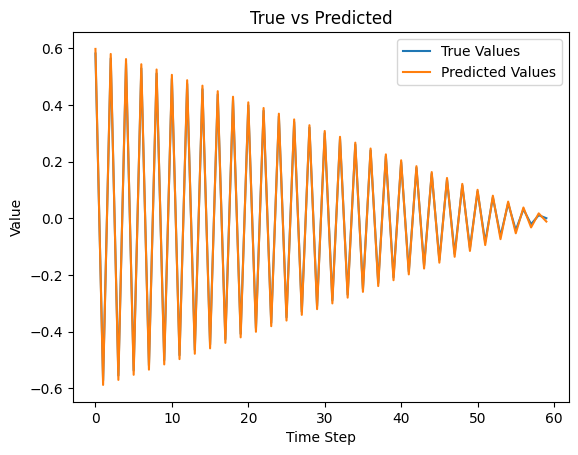

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate sine wave data
def generate_sine_wave(seq_length: int, num_samples: int):
    x = np.linspace(0, num_samples * np.pi, num_samples)
    y = np.sin(x)
    return y

# Prepare the dataset: Create sequences with input length = seq_length
def create_dataset(data: np.ndarray, seq_length: int):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])

    sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # Shape: [batch_size, seq_length, 1]
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(-1)        # Shape: [batch_size, 1]
    return sequences, labels

# Define the RNN-based Neural Network architecture
class RNNModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

# Function to train the model
def train_rnn_model(model: nn.Module,
                    X_train: torch.Tensor,
                    y_train: torch.Tensor,
                    criterion: nn.Module,
                    optimizer: optim.Optimizer,
                    epochs: int = 100,
                    device: torch.device = 'cpu') -> None:

    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Function to test the model
def test_rnn_model(model: nn.Module, X_test: torch.Tensor, device: torch.device = 'cpu') -> torch.Tensor:
    model.to(device)
    X_test = X_test.to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    return predictions.cpu().numpy()

# Plot the true vs predicted values
def plot_predictions(true_values: np.ndarray, predicted_values: np.ndarray, title: str = 'True vs Predicted'):
    plt.plot(true_values, label='True Values')
    plt.plot(predicted_values, label='Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

# Main execution flow
if __name__ == "__main__":
    # Hyperparameters
    seq_length = 50
    num_samples = 300
    hidden_size = 20
    output_size = 1  # Predict one value at a time
    num_layers = 2
    epochs = 1000
    learning_rate = 0.001

    # Generate sine wave data
    sine_wave = generate_sine_wave(seq_length, num_samples)

    # Split the data into training and testing sets
    train_size = int(num_samples * 0.8)
    test_size = num_samples - train_size
    train_data = sine_wave[:train_size]
    test_data = sine_wave[train_size - seq_length:]  # Include some overlap for testing

    # Create datasets for training and testing
    X_train, y_train = create_dataset(train_data, seq_length)
    X_test, y_test = create_dataset(test_data, seq_length)

    # Define device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, loss function, and optimizer
    model = RNNModel(input_size=1, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
    criterion = nn.MSELoss()  # Regression task, so use Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_rnn_model(model, X_train, y_train, criterion, optimizer, epochs, device)

    # Test the model and get predictions
    predictions = test_rnn_model(model, X_test, device)

    # Plot the true vs predicted values for the test set
    plot_predictions(y_test.numpy(), predictions)

## Convolutional Neural Network for Image Classification (CNN)

A **Convolutional Neural Network (CNN)** is designed to process grid-like data, such as images, by applying convolutional filters to capture local patterns and features. CNNs are particularly useful for tasks such as **image classification**, **object detection**, and **image segmentation**.

### Problem Description:
We use a CNN to classify images from a dataset (e.g., MNIST, CIFAR-10). The goal is to predict the correct label (category) for each image based on learned spatial features.

### CNN:
1. **Convolution Operation**:
   $$ (f * g)(i, j) = \sum_m \sum_n f(m, n) \, g(i - m, j - n) $$
   where:
   - \( f \) is the input image
   - \( g \) is the convolution kernel (filter)

2. **Pooling Operation**:
   Pooling reduces the spatial dimensions of the feature maps. For max pooling:
   $$ p(i, j) = \text{max}(x_{i:a, j:b}) $$
   where \( a, b \) define the pooling window.

3. **Fully Connected Layer**:
   The output from the convolutional and pooling layers is flattened and passed through a fully connected layer:
   $$ y = W x + b $$
   where \( W \) and \( b \) are the weights and biases of the fully connected layer.

### Steps:
1. Load and preprocess image data (e.g., MNIST, CIFAR-10).
2. Define a CNN with convolutional, pooling, and fully connected layers.
3. Train the network using cross-entropy loss for classification.
4. Test the model on unseen images and evaluate accuracy.


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 15952029.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 489607.27it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4462945.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 6820812.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Loss: 0.2032
Epoch [2/5], Loss: 0.0536
Epoch [3/5], Loss: 0.0382
Epoch [4/5], Loss: 0.0272
Epoch [5/5], Loss: 0.0227
Accuracy: 98.39%


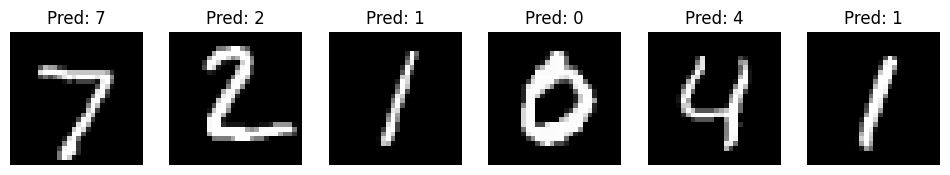

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layer 1: 1 input channel (grayscale), 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # Convolutional layer 2: 16 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Fully connected layer 1
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        # Fully connected layer 2 (output layer)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply first convolution, followed by ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # Apply second convolution, followed by ReLU and max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 32 * 7 * 7)
        # Apply first fully connected layer with ReLU
        x = F.relu(self.fc1(x))
        # Output layer (no activation here since we use CrossEntropyLoss later)
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Function to test the model
def test_model(model, test_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

# Main execution
if __name__ == "__main__":
    # Device configuration (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Transformations: convert images to tensors and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load the MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # Initialize the CNN model
    model = CNN().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, epochs=5, device=device)

    # Test the model
    test_model(model, test_loader, device=device)

    # Visualize some test results
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Show a few test images and their predicted labels
    images = images.cpu()
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {predicted[i].item()}')
        axes[i].axis('off')
    plt.show()

## Quantum Neural Network (QNN)

A **Quantum Neural Network (QNN)** combines concepts from quantum computing and classical neural networks. Quantum neural networks leverage quantum bits (qubits) and quantum gates to perform operations, which may offer computational advantages in certain tasks like optimization, classification, or quantum data processing.

### Problem Description:
A QNN is designed to solve problems where quantum data or quantum properties (like entanglement or superposition) can provide computational benefits. We aim to use a QNN to classify data by using a quantum circuit as part of the model.

### QNN Architecture:
1. **Quantum Circuit**:
   - The core of a QNN involves a parameterized quantum circuit (PQC) consisting of qubits and quantum gates (e.g., Hadamard, Pauli-X, rotation gates).
   - The gates' parameters are adjusted during training, similar to how weights are adjusted in classical neural networks.

2. **Hybrid Classical-Quantum Model**:
   - A QNN is often **hybrid**, meaning it combines classical neural network layers and quantum layers. The classical layers handle preprocessing or postprocessing, while the quantum layers perform the core computations.
   
3. **Quantum Gates and Qubits**:
   - Quantum gates act on qubits, manipulating their states in superposition. Common gates used in QNNs include:
     - **Hadamard Gate**: Creates superposition.
     - **Pauli-X Gate**: Quantum NOT gate (flip).
     - **Rotation Gates (Rz, Rx, Ry)**: Parameterized gates that rotate qubits by some angle.

4. **Training**:
   - The QNN is trained using techniques such as **variational quantum algorithms** where a classical optimizer (e.g., gradient descent) tunes the parameters of the quantum gates to minimize a loss function.

### Steps:
1. Encode classical data (features) into quantum states using a quantum circuit.
2. Construct the quantum circuit with parameterized gates and apply measurements.
3. Combine quantum operations with classical layers for postprocessing.
4. Train the model by adjusting quantum gate parameters to minimize the loss.
5. Use the trained QNN to classify data or make predictions.


In [ ]:
!pip install pennylane --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00


Epoch [5/200], Loss: 0.6871
Epoch [10/200], Loss: 0.6708
Epoch [15/200], Loss: 0.6647
Epoch [20/200], Loss: 0.6631
Epoch [25/200], Loss: 0.6611
Epoch [30/200], Loss: 0.6578
Epoch [35/200], Loss: 0.6544
Epoch [40/200], Loss: 0.6514
Epoch [45/200], Loss: 0.6490
Epoch [50/200], Loss: 0.6466
Epoch [55/200], Loss: 0.6442
Epoch [60/200], Loss: 0.6419
Epoch [65/200], Loss: 0.6397
Epoch [70/200], Loss: 0.6376
Epoch [75/200], Loss: 0.6355
Epoch [80/200], Loss: 0.6334
Epoch [85/200], Loss: 0.6313
Epoch [90/200], Loss: 0.6293
Epoch [95/200], Loss: 0.6272
Epoch [100/200], Loss: 0.6252
Epoch [105/200], Loss: 0.6232
Epoch [110/200], Loss: 0.6212
Epoch [115/200], Loss: 0.6193
Epoch [120/200], Loss: 0.6173
Epoch [125/200], Loss: 0.6153
Epoch [130/200], Loss: 0.6134
Epoch [135/200], Loss: 0.6115
Epoch [140/200], Loss: 0.6096
Epoch [145/200], Loss: 0.6077
Epoch [150/200], Loss: 0.6059
Epoch [155/200], Loss: 0.6040
Epoch [160/200], Loss: 0.6022
Epoch [165/200], Loss: 0.6004
Epoch [170/200], Loss: 0.5986


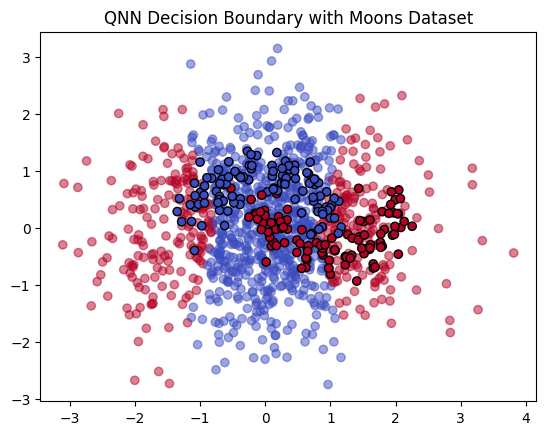

In [ ]:
import pennylane as qml
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Define a quantum device with 2 qubits
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit (Ansatz)
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    # Encoding classical inputs into quantum states
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))

    # Quantum layer: Apply a variational layer of rotations and entanglement
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the hybrid quantum-classical layer
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        # Randomly initialize weights for the quantum layer
        self.weight = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits))

    def forward(self, x):
        # Apply the quantum circuit for each input and convert the output to float32 tensors
        results = [torch.tensor(quantum_circuit(x[i], self.weight), dtype=torch.float32) for i in range(len(x))]
        return torch.stack(results)

# Classical Neural Network with a quantum layer
class HybridQNN(nn.Module):
    def __init__(self):
        super(HybridQNN, self).__init__()
        # Quantum layer with 2 qubits and 1 layer
        self.quantum_layer = QuantumLayer(n_qubits=2, n_layers=1)
        # Classical fully connected layer
        self.fc = nn.Linear(2, 2)

    def forward(self, x):
        # Pass through the quantum layer
        x = self.quantum_layer(x)
        # Pass through a classical fully connected layer
        x = self.fc(x)
        return x

# Training function
def train_qnn(model, optimizer, criterion, X_train, y_train, epochs=10):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Create a more interesting dataset using the Moons dataset
def generate_moons_data():
    X, y = make_moons(n_samples=200, noise=0.2, random_state=0)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Main execution
if __name__ == "__main__":
    # Generate data
    X_train, y_train = generate_moons_data()

    # Initialize the hybrid QNN model
    model = HybridQNN()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    train_qnn(model, optimizer, criterion, X_train, y_train, epochs=200)

    # Visualize decision boundary
    model.eval()
    with torch.no_grad():
        # Generate test data for visualization
        X_test = torch.tensor(np.random.randn(1000, 2), dtype=torch.float32)
        y_test = model(X_test).argmax(dim=1)

    # Plot decision boundary with original data points for reference
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.5)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')
    plt.title("QNN Decision Boundary with Moons Dataset")
    plt.show()

# Generative Models:
We use generative models to learn the underlying data distribution and generate new, similar data.

- **Generative Adversarial Network (GAN)**:  
  consists of two networks—a **generator** that creates synthetic data and a **discriminator** that distinguishes between real and fake data. The networks train in opposition, resulting in the generator producing realistic data samples.

- **Variational Autoencoder (VAE)**:  
  is a type of autoencoder that learns a probabilistic mapping from input data to a lower-dimensional latent space. It generates new samples by decoding points sampled from the latent space, making it suitable for generating data with a specific structure.



## Generative Adversarial Network (GAN)

A **Generative Adversarial Network (GAN)** is a type of neural network architecture that consists of two models: a **generator** and a **discriminator**, which are trained together in a competitive process. GANs are used to generate new data that is similar to the input training data, such as generating realistic images, audio, or text.

### Problem Description:
We use a GAN to generate realistic-looking images based on random noise. The **generator** creates new images, and the **discriminator** tries to distinguish between real and generated images. The generator improves over time by learning to fool the discriminator.

### GAN Architecture:
1. **Generator**:
   The generator takes random noise (latent space vector) as input and transforms it into a data sample (e.g., an image).
   $$ z \xrightarrow{G(z)} \text{Generated Image} $$

2. **Discriminator**:
   The discriminator receives real or generated data and classifies it as real or fake.
   $$ x \xrightarrow{D(x)} \{0, 1\} $$

3. **Adversarial Loss**:
   - The generator tries to minimize the probability that the discriminator classifies generated data as fake.
   - The discriminator tries to maximize the probability of correctly identifying real and fake data.
   
   The loss functions for the generator and discriminator are:
   - **Generator Loss**:
     $$ \mathcal{L}_G = \log(1 - D(G(z))) $$
   - **Discriminator Loss**:
     $$ \mathcal{L}_D = -[\log D(x) + \log(1 - D(G(z)))] $$

### Steps:
1. Initialize the **generator** and **discriminator** models.
2. Train the models iteratively: the generator learns to create more realistic data, while the discriminator improves at distinguishing between real and fake data.
3. Generate new data using the trained generator and evaluate the quality of generated samples.


Epoch [1/10] | Loss D: 0.2638 | Loss G: 3.4803
Epoch [2/10] | Loss D: 0.4806 | Loss G: 2.0817
Epoch [3/10] | Loss D: 0.5634 | Loss G: 3.4624
Epoch [4/10] | Loss D: 0.5018 | Loss G: 5.3606
Epoch [5/10] | Loss D: 0.1868 | Loss G: 5.4010
Epoch [6/10] | Loss D: 0.5100 | Loss G: 6.1958
Epoch [7/10] | Loss D: 0.1350 | Loss G: 3.8525
Epoch [8/10] | Loss D: 0.1133 | Loss G: 6.2886
Epoch [9/10] | Loss D: 0.1715 | Loss G: 5.3519
Epoch [10/10] | Loss D: 0.1420 | Loss G: 5.4859


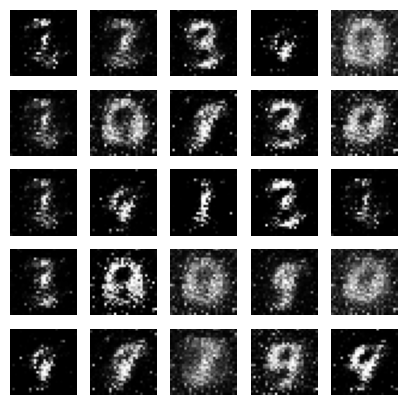

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()  # Output image range will be between [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # Output a probability between [0, 1]
        )

    def forward(self, x):
        return self.net(x)

# Function to create noise for the generator
def create_noise(batch_size, input_size):
    return torch.randn(batch_size, input_size)

# Function to train the GAN
def train_gan(generator, discriminator, criterion, optimizer_g, optimizer_d, data_loader, epochs, device='cpu', latent_size=100):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for real_images, _ in data_loader:
            real_images = real_images.view(real_images.size(0), -1).to(device)  # Flatten the images
            batch_size = real_images.size(0)

            # Train the Discriminator
            noise = create_noise(batch_size, latent_size).to(device)
            fake_images = generator(noise)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()

            # Discriminator loss on real and fake data
            outputs_real = discriminator(real_images)
            outputs_fake = discriminator(fake_images.detach())  # Detach to avoid generator gradients
            loss_real = criterion(outputs_real, real_labels)
            loss_fake = criterion(outputs_fake, fake_labels)
            loss_d = loss_real + loss_fake

            loss_d.backward()
            optimizer_d.step()

            # Train the Generator
            noise = create_noise(batch_size, latent_size).to(device)
            fake_images = generator(noise)

            optimizer_g.zero_grad()

            outputs_fake = discriminator(fake_images)
            loss_g = criterion(outputs_fake, real_labels)  # Generator wants to fool the discriminator

            loss_g.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch + 1}/{epochs}] | Loss D: {loss_d.item():.4f} | Loss G: {loss_g.item():.4f}')

# Function to visualize generated images
def show_generated_images(generator, latent_size, num_images=25, device='cpu'):
    generator.eval()
    noise = create_noise(num_images, latent_size).to(device)
    generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()

    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    latent_size = 100
    hidden_size = 256
    image_size = 28 * 28  # MNIST images are 28x28
    batch_size = 64
    epochs = 10
    learning_rate = 0.0002

    # Data transformation and loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize between [-1, 1]
    ])

    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

    # Initialize the Generator and Discriminator
    generator = Generator(latent_size, hidden_size, image_size).to(device)
    discriminator = Discriminator(image_size, hidden_size).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

    # Train the GAN
    train_gan(generator, discriminator, criterion, optimizer_g, optimizer_d, data_loader, epochs, device, latent_size)

    # Show generated images
    show_generated_images(generator, latent_size, device=device)

## Variational Autoencoder (VAE)

A **Variational Autoencoder (VAE)** is a generative model that learns to encode input data into a latent space, and then decodes samples from this space back into the data space. The goal of a VAE is to model data generation by sampling from a learned latent distribution.

### Problem Description:
We use a VAE to encode images into a lower-dimensional latent space and then generate new images by sampling from this latent space. VAEs are particularly useful for generating new data points similar to the input data, as well as performing smooth interpolation between data points in the latent space.

### VAE Architecture:
1. **Encoder**:
   - Maps input data $x$ to a latent representation $z$ using a neural network.
   - Instead of mapping to a single point, it learns the **mean** $\mu$ and **variance** $\sigma^2$ of a distribution for each latent variable:
   $$ z \sim q(z | x) = \mathcal{N}(\mu(x), \sigma^2(x)) $$

2. **Latent Space Sampling**:
   - The latent vector $z$ is sampled from the learned distribution:
   $$ z = \mu + \sigma \odot \epsilon, \, \epsilon \sim \mathcal{N}(0, I) $$

3. **Decoder**:
   - The decoder maps the latent vector $z$ back into the original data space to reconstruct $x$:
   $$ x' = p(x | z) $$

4. **Loss Function**:
   - The VAE uses two losses: **Reconstruction Loss** to measure how well the model can reconstruct the input, and **KL Divergence** to regularize the latent space:
   $$ \mathcal{L} = \mathcal{L}_{\text{reconstruction}} + \text{KL}(q(z | x) || p(z)) $$

### Steps:
1. Initialize the **encoder** and **decoder** networks.
2. Train the model to minimize reconstruction loss and KL divergence.
3. Use the trained model to generate new data by sampling from the latent space.


Epoch [1/10], Loss: 145.9870
Epoch [2/10], Loss: 115.6417
Epoch [3/10], Loss: 111.2783
Epoch [4/10], Loss: 109.2627
Epoch [5/10], Loss: 108.1346
Epoch [6/10], Loss: 107.3173
Epoch [7/10], Loss: 106.7304
Epoch [8/10], Loss: 106.2231
Epoch [9/10], Loss: 105.8789
Epoch [10/10], Loss: 105.5283


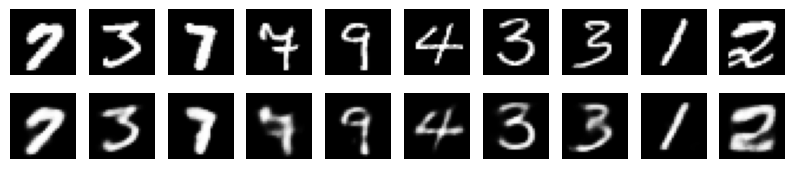

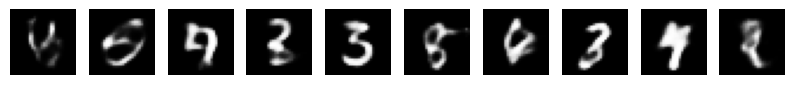

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, latent_size)  # Mean vector
        self.fc_logvar = nn.Linear(hidden_size, latent_size)  # Log variance vector

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

# Define the VAE that combines Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Sample epsilon from N(0,1)
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# VAE Loss Function: combines reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence between the learned latent distribution and N(0,1)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Function to train the VAE
def train_vae(model, data_loader, optimizer, epochs=10, device='cpu'):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in data_loader:
            images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()

            recon_images, mu, logvar = model(images)
            loss = vae_loss(recon_images, images, mu, logvar)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(data_loader.dataset):.4f}')

# Function to visualize reconstructed and generated images
def visualize_vae(model, data_loader, latent_size, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        images, _ = next(iter(data_loader))
        images = images.view(-1, 28 * 28).to(device)
        recon_images, _, _ = model(images)

        # Visualize the original and reconstructed images
        images = images.view(-1, 1, 28, 28).cpu()
        recon_images = recon_images.view(-1, 1, 28, 28).cpu()

        fig, axes = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(10):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')

        plt.show()

        # Generate new images by sampling from the latent space
        sample_z = torch.randn(10, latent_size).to(device)
        generated_images = model.decoder(sample_z).view(-1, 1, 28, 28).cpu()

        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
            axes[i].axis('off')

        plt.show()

# Main execution
if __name__ == "__main__":
    # Device configuration (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    input_size = 28 * 28  # MNIST images are 28x28
    hidden_size = 400
    latent_size = 20  # Size of the latent space
    batch_size = 64
    epochs = 10
    learning_rate = 1e-3

    # Data loader with proper normalization for binary cross-entropy
    transform = transforms.Compose([
        transforms.ToTensor()  # Automatically scales pixel values to [0, 1]
    ])

    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

    # Initialize the VAE model
    model = VAE(input_size, hidden_size, latent_size).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the VAE
    train_vae(model, data_loader, optimizer, epochs, device)

    # Visualize reconstructed and generated images
    visualize_vae(model, data_loader, latent_size, device)


# Reinforcement Learning

**Reinforcement Learning (RL)** is a type of machine learning where an agent learns to make decisions by interacting with an environment. The agent aims to maximize cumulative rewards over time by taking actions that lead to favorable outcomes.

## Reinforcement Learning (RL)

### Problem Description:
In RL, the agent explores an environment to find an optimal policy (strategy) that determines the best action to take in each state. The goal is to learn a policy that maximizes the total reward over time, known as the **cumulative reward** or **return**.

### Key Concepts:
1. **Agent**: The decision-maker that interacts with the environment.
2. **Environment**: The system with which the agent interacts.
3. **State ($s$)**: The current situation or observation from the environment.
4. **Action ($a$)**: A choice made by the agent that changes the state.
5. **Reward ($r$)**: Feedback received from the environment for taking an action in a state.
6. **Policy ($\pi$)**: A mapping from states to actions that defines the agent's behavior.
7. **Value Function ($V(s)$)**: Estimates the expected cumulative reward starting from state $s$ and following a policy.

### Reinforcement Learning Process:
1. **Exploration**: The agent tries new actions to discover their effects.
2. **Exploitation**: The agent uses knowledge of past actions to maximize rewards.
3. **Learning**: The agent updates its policy or value function based on rewards.

### Types of RL Algorithms:
1. **Model-Free RL**: The agent learns directly from interactions with the environment without knowing the transition probabilities (e.g., Q-Learning, Deep Q-Networks).
2. **Model-Based RL**: The agent learns a model of the environment to predict the outcome of actions (e.g., Dyna-Q).

### RL Objective:
The agent aims to learn a policy $\pi$ that maximizes the expected sum of rewards:
$$ \max \, \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^t r_{t+1} \right] $$
Where:
- $\gamma$ is the **discount factor** (0 ≤ $\gamma$ ≤ 1) that determines the importance of future rewards.

### Steps:
1. Define the **state space**, **action space**, and **reward function**.
2. Choose an RL algorithm (e.g., Q-Learning, DQN, Policy Gradient).
3. Train the agent through episodes of interaction with the environment.
4. Evaluate the learned policy and adjust parameters for improvement.


Episode: 100, Total Reward: 27.0, Avg Reward: 21.83, Exploration Rate: 0.9522
Episode: 200, Total Reward: 21.0, Avg Reward: 21.29, Exploration Rate: 0.9062
Episode: 300, Total Reward: 14.0, Avg Reward: 21.83, Exploration Rate: 0.8625
Episode: 400, Total Reward: 15.0, Avg Reward: 19.83, Exploration Rate: 0.8209
Episode: 500, Total Reward: 18.0, Avg Reward: 21.55, Exploration Rate: 0.7814
Episode: 600, Total Reward: 14.0, Avg Reward: 22.70, Exploration Rate: 0.7438
Episode: 700, Total Reward: 19.0, Avg Reward: 21.53, Exploration Rate: 0.7080
Episode: 800, Total Reward: 10.0, Avg Reward: 20.84, Exploration Rate: 0.6739
Episode: 900, Total Reward: 17.0, Avg Reward: 21.38, Exploration Rate: 0.6416
Episode: 1000, Total Reward: 28.0, Avg Reward: 21.81, Exploration Rate: 0.6108


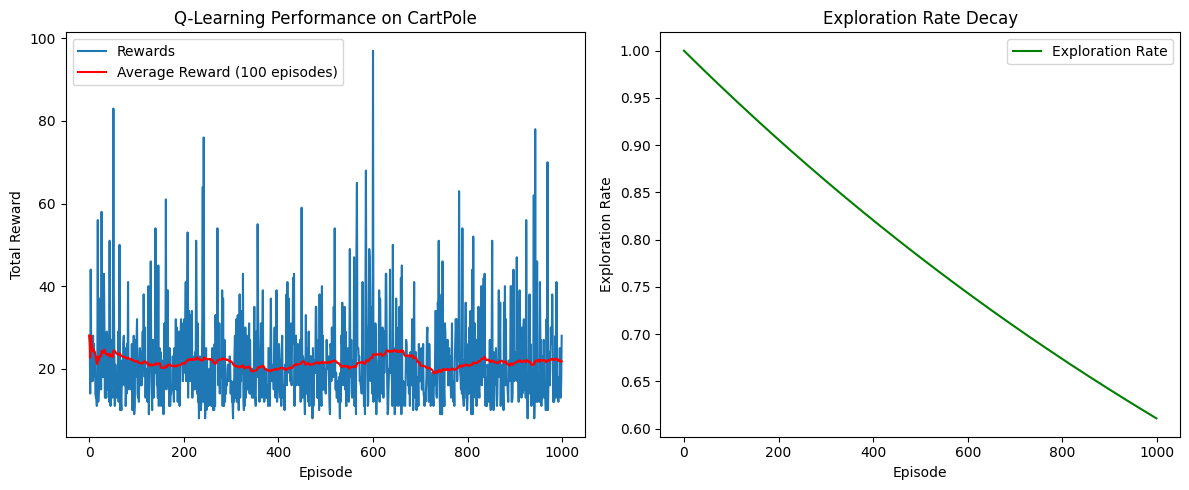

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.


Total reward during test run: 24.0
Video saved in ./videos


In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import os

# Create the environment
env = gym.make('CartPole-v1', new_step_api=True)

# Q-Learning hyperparameters
learning_rate = 0.05
discount_factor = 0.99  # Gamma: discount factor for future rewards
exploration_rate = 1.0  # Epsilon: initial exploration rate
max_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.0005

# Discretization parameters
state_space_bins = [30, 30, 50, 50]  # More bins for better resolution
q_table = np.random.uniform(low=-1, high=1, size=(state_space_bins + [env.action_space.n]))

# Updated Discretization function with clipping
def discretize_state(state):
    state_low = [-2.4, -3.0, -0.5, -3.0]  # Define reasonable lower bounds for CartPole states
    state_high = [2.4, 3.0, 0.5, 3.0]  # Define reasonable upper bounds for CartPole states
    state_bins = []

    for i in range(len(state)):
        # Clip state values to the defined lower and upper bounds
        state_value = np.clip(state[i], state_low[i], state_high[i])
        # Discretize state values into bins
        state_bin = int((state_value - state_low[i]) / (state_high[i] - state_low[i]) * state_space_bins[i])
        state_bin = np.clip(state_bin, 0, state_space_bins[i] - 1)  # Ensure the bin index is within bounds
        state_bins.append(state_bin)

    return tuple(state_bins)

# Q-Learning algorithm
def q_learning(env, q_table, episodes=5000, max_steps=200):
    global exploration_rate

    rewards = []
    average_rewards = []
    exploration_rates = []

    for episode in range(episodes):
        state = discretize_state(env.reset())
        total_rewards = 0

        for step in range(max_steps):
            # Choose action: Exploration vs Exploitation
            if np.random.rand() < exploration_rate:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(q_table[state])  # Exploit

            # Take action, observe new state and reward
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = discretize_state(next_state)

            # Update Q-Table using the Q-Learning update rule
            q_value = q_table[state + (action,)]
            max_future_q = np.max(q_table[next_state])
            new_q_value = (1 - learning_rate) * q_value + learning_rate * (reward + discount_factor * max_future_q)
            q_table[state + (action,)] = new_q_value

            state = next_state
            total_rewards += reward

            if done:
                break

        # Reduce exploration rate
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
        rewards.append(total_rewards)
        exploration_rates.append(exploration_rate)

        # Calculate the average reward for the last 100 episodes
        if len(rewards) >= 100:
            average_reward = np.mean(rewards[-100:])
            average_rewards.append(average_reward)
        else:
            average_rewards.append(np.mean(rewards))

        # Print progress
        if (episode + 1) % 100 == 0:
            print(f'Episode: {episode + 1}, Total Reward: {total_rewards}, Avg Reward: {average_rewards[-1]:.2f}, Exploration Rate: {exploration_rate:.4f}')

    return rewards, average_rewards, exploration_rates

# Main execution
if __name__ == "__main__":
    # Train the agent using Q-Learning
    episodes = 1000
    rewards, average_rewards, exploration_rates = q_learning(env, q_table, episodes=episodes)

    # Plot the rewards over episodes
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label='Rewards')
    plt.plot(average_rewards, label='Average Reward (100 episodes)', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-Learning Performance on CartPole')
    plt.legend()

    # Plot exploration rate over episodes
    plt.subplot(1, 2, 2)
    plt.plot(exploration_rates, label='Exploration Rate', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Exploration Rate')
    plt.title('Exploration Rate Decay')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Record a video of the trained agent
    video_dir = "./videos"
    os.makedirs(video_dir, exist_ok=True)

    # Wrap the environment to record a video
    env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda x: x % 1000 == 0, new_step_api=True)

    state = discretize_state(env.reset())
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = discretize_state(next_state)
        total_reward += reward

    print(f'Total reward during test run: {total_reward}')
    env.close()
    print(f"Video saved in {video_dir}")


In [ ]:
from IPython.display import HTML
import base64

def show_video(video_path):
    video = open(video_path, 'rb').read()
    video_b64 = base64.b64encode(video).decode('ascii')
    return HTML(f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_b64}" type="video/mp4"></video>')

# Show the last video saved
video_files = sorted([f for f in os.listdir(video_dir) if f.endswith('.mp4')])
show_video(os.path.join(video_dir, video_files[-1]))

# Natural Language Processing

- **Chatbot with Transformer Models**:  
A chatbot is a conversational agent that interacts with users in natural language. Using pre-trained transformer models like GPT (Generative Pre-trained Transformers), chatbots can understand and generate human-like responses. The goal is to create a chatbot that can hold coherent and contextually relevant conversations with users over multiple turns.

- **Language Modeling and Text Generation**:  
Language modeling is the task of predicting the next word or sequence of words in a sentence based on the context provided by previous words. Using pre-trained GPT (Generative Pre-trained Transformer) models, we can train a model to generate creative text, such as poetry or short stories, and build a text autocomplete system. The goal is to create a model that understands the structure and style of the input text and can generate coherent, contextually appropriate continuations.

## Chatbot with Transformer Models

### Problem Description:
A chatbot is a conversational agent that interacts with users in natural language. Using pre-trained transformer models like GPT (Generative Pre-trained Transformers), chatbots can understand and generate human-like responses. The goal is to create a chatbot that can hold coherent and contextually relevant conversations with users over multiple turns.

### Key Concepts:
1. **Transformer Models**: Deep learning models designed to understand the context and relationships between words in a sequence. They excel in tasks like language understanding and generation.
2. **Tokenization**: The process of breaking down text into smaller units (tokens) that the model can understand.
3. **Context**: The previous conversation history that helps the model generate responses relevant to the current input.
4. **Inference**: The process of generating a response based on user input using a pre-trained model.
5. **Pre-Trained Model**: A model that has been trained on a large corpus of text data and can be fine-tuned for specific tasks (e.g., GPT-2, DialoGPT).

### Chatbot Process:
1. **Input Processing**: The user inputs a message, which is tokenized for the model to understand.
2. **Generate Response**: The model uses the input and conversation history to generate a relevant response.
3. **Output Decoding**: The generated tokens are decoded back into human-readable text.
4. **Conversation Flow**: The chat history is updated with each interaction, allowing the model to maintain context across multiple turns.


### Steps:
1. **Select a Pre-Trained Model**: Choose a model like GPT-2 or DialoGPT that is suitable for conversational tasks.
2. **Tokenize Input**: Process user input into tokens that the model can understand.
3. **Generate Responses**: Use the model to generate a response based on the input and conversation history.
4. **Decode Output**: Convert the model's output tokens back into human-readable text.
5. **Conversation Management**: Update the conversation history with each user and chatbot interaction to maintain context.
6. **Fine-Tuning**: Optionally, fine-tune the model on domain-specific conversations to improve relevance and accuracy.



In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load pre-trained DialoGPT model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def generate_response(input_text, chat_history_ids=None):
    # Encode the user input and add end-of-string token
    new_user_input_ids = tokenizer.encode(input_text + tokenizer.eos_token, return_tensors='pt')

    # Append the new user input to the chat history (if any)
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if chat_history_ids is not None else new_user_input_ids

    # Generate the response
    chat_history_ids = model.generate(
        bot_input_ids,
        max_length=1000,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )

    # Decode the response and print it
    response = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    return response, chat_history_ids

# Initialize the chat history
chat_history_ids = None
print("Chatbot is ready! Type 'quit' to end the conversation.")

while True:
    # Get user input
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        print("Ending the chat. Have a great day!")
        break

    # Generate response
    response, chat_history_ids = generate_response(user_input, chat_history_ids)

    print(f"Chatbot: {response}")

Chatbot is ready! Type 'quit' to end the conversation.
You: Hi
Chatbot: Hi!
You: What is the weather like today?
Chatbot: It's getting colder. It's been freezing for the last few days.
You: Tell me a joke.
Chatbot: Did you hear about Pluto?
You: No
Chatbot: It wasn't a joke.
You: quit
Ending the chat. Have a great day!


## Language Modeling and Text Generation

### Problem Description:
Language modeling is the task of predicting the next word or sequence of words in a sentence based on the context provided by previous words. Using pre-trained GPT (Generative Pre-trained Transformer) models, we can train a model to generate creative text, such as poetry or short stories, and build a text autocomplete system. The goal is to create a model that understands the structure and style of the input text and can generate coherent, contextually appropriate continuations.

### Key Concepts:
1. **Language Model**: A model that learns the probability of a word or sequence of words occurring based on the context provided by preceding words.
2. **Pre-Trained Model**: A model like GPT-2 that has been trained on a large corpus of text data and can be fine-tuned for specific text generation tasks.
3. **Tokenization**: The process of converting text into tokens that the model can understand, such as words or subwords.
4. **Fine-Tuning**: The process of further training a pre-trained model on a specific dataset to adapt it to a particular style or domain.
5. **Creative Writing**: Using the model to generate poetry, short stories, or other forms of creative text based on a given prompt.
6. **Text Autocomplete**: Predicting and suggesting completions for partial text inputs, similar to how search engines provide suggestions as users type.

### Language Modeling Process:
1. **Data Collection**: Gather a dataset of creative writing samples (e.g., poetry, short stories) for fine-tuning.
2. **Tokenize Text**: Process the text into tokens using a tokenizer compatible with the chosen GPT model.
3. **Fine-Tune the Model**: Train the pre-trained GPT model on the dataset to capture the style and structure of creative writing.
4. **Generate Text**: Provide a prompt to the model and generate creative continuations.
5. **Autocomplete System**: Use the model to suggest likely continuations for user inputs in real-time.

### Types of Language Models:
1. **Generative Language Models**: Create new text sequences based on input prompts (e.g., GPT-2, GPT-3).
2. **Masked Language Models**: Predict missing words in a sentence (e.g., BERT).
3. **Seq2Seq Models**: Translate or transform one sequence into another (e.g., for translation or summarization tasks).

### Language Modeling Objective:
The goal is to train a GPT-based model to:
- Generate creative text that matches the style and theme of the input.
- Autocomplete partial sentences by suggesting relevant continuations.
- Adapt to different creative tasks such as poetry generation or story continuation.

### Steps:
1. **Select a Pre-Trained Model**: Choose a model like GPT-2 from the Hugging Face Transformers library.
2. **Prepare Data**: Tokenize the dataset of creative writing samples.
3. **Fine-Tune the Model**: Train the model using the prepared dataset to adapt it to the desired style.
4. **Text Generation**: Use the fine-tuned model to generate text based on user prompts.
5. **Build Autocomplete**: Use the model to predict likely word sequences based on partially typed text.
6. **Interactive Example**: Create a loop where users can input a prompt, and the model generates creative continuations.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def generate_text(prompt, max_length=100, temperature=0.7):
    # Encode the input prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    # Generate text using the GPT-2 model with sampling
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        temperature=temperature,  # Controls randomness in generation
        top_k=50,                 # Filters the most likely words
        top_p=0.95,               # Nucleus sampling
        do_sample=True,           # Enables sampling for more creative results
        no_repeat_ngram_size=2,   # Prevents repeating phrases
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode the output to readable text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return generated_text

# Example prompt for generating a poem
prompt = "The sun dipped below the horizon, casting a golden glow over the sea"
generated_poem = generate_text(prompt, max_length=100)
print("Prompt:\n", prompt)
print("Generated Poem:\n", generated_poem)


Prompt:
 The sun dipped below the horizon, casting a golden glow over the sea
Generated Poem:
 The sun dipped below the horizon, casting a golden glow over the sea of green. The rain fell from the sky, and the clouds floated over it.

The moon rose in a flash, the sun's rays hitting the moon like a jet and leaving a cloud of red in its wake. Then the rays of the wind swept through the air, illuminating the night sky with its shimmering light. An incredible amount of light shone through its blackened surface, creating a perfect storm of sparks and


In [ ]:
def autocomplete_text(prompt, max_length=50, temperature=0.7):
    # Encode the input prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    # Generate text that completes the prompt using sampling
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        temperature=temperature,  # Controls randomness (higher values = more diverse outputs)
        top_k=50,                 # Filters to the top 50 most likely next tokens
        top_p=0.9,                # Uses nucleus sampling (picking from the top 90% probability mass)
        do_sample=True,           # Enables sampling for more creative output
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and return the completion
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

# Example prompt for autocomplete
prompt = "In the quiet forest, a fox"
completion = autocomplete_text(prompt, max_length=50)
print("Prompt:", prompt)
print("Autocomplete Suggestion:\n", completion)

Prompt: In the quiet forest, a fox
Autocomplete Suggestion: In the quiet forest, a fox is a fox, and a wolf is a wolf, and a bear is a bear.


In [ ]:
print("Welcome to the Text Generation Demo! Type 'quit' to exit.")

while True:
    user_prompt = input("Enter a prompt: ")
    if user_prompt.lower() == 'quit':
        print("Goodbye!")
        break

    # Generate creative continuation
    generated_text = generate_text(user_prompt, max_length=100)
    print("\nGenerated Text:\n", generated_text)


Welcome to the Text Generation Demo! Type 'quit' to exit.
Enter a prompt: The ancient oak tree stood tall in the clearing, its branches

Generated Text:
 The ancient oak tree stood tall in the clearing, its branches hanging from its trunk.

"What's the matter with this?"
...
-
There was a long silence, and then, as if the sky were changing, the sound of the wind rose to a loud and sudden roar. As if by magic, a large black blade pierced through the oak's branches, piercing the tree with its long blade. The blade struck the branch, cutting it in half and killing it
Enter a prompt: quit
Goodbye!


# Quantum Computing

## HHL Algorithm

### Problem Description:
The **HHL algorithm** is a quantum algorithm for solving systems of linear equations of the form:
$$
A \vec{x} = \vec{b}
$$
where:
- $A$ is a Hermitian matrix.
- $\vec{x}$ is the unknown vector.
- $\vec{b}$ is a known vector.

This example uses a simplified version of the HHL algorithm to solve a **linear system** using quantum methods like **Quantum Phase Estimation (QPE)** and **Quantum Fourier Transform (QFT)**. The goal is to demonstrate how quantum algorithms can be used to find $\vec{x}$ in a linear equation system, leveraging the capabilities of quantum computation.

### Key Concepts:
1. **Quantum Fourier Transform (QFT)**: A quantum analogue of the classical Fourier transform that is used in QPE to extract phase information.
2. **Quantum Phase Estimation (QPE)**: An algorithm that estimates the eigenvalues of a unitary operator, crucial for determining the eigenvalues of $A$.
3. **Controlled Rotations**: Adjust the quantum state amplitudes based on eigenvalues, effectively performing the division operation in the HHL algorithm.
4. **Inverse QFT**: Uncomputes the QFT to return the system to a state where measurements yield the solution.
5. **State Preparation**: The vector $\vec{b}$ is encoded into a quantum state $|b\rangle$.

### Quantum Algorithm Process:
1. **State Preparation**:
   - Encode $\vec{b}$ as a quantum state using a rotation gate.
2. **Quantum Phase Estimation (QPE)**:
   - Apply the QFT and controlled operations to estimate the eigenvalues of the matrix $A$.
3. **Controlled Rotation**:
   - Apply rotations based on the estimated eigenvalues to prepare for the inversion.
4. **Inverse QFT**:
   - Perform the inverse QFT to disentangle the quantum state, returning to the solution space.
5. **Measurement**:
   - Measure the resulting quantum state, which encodes the solution vector $\vec{x}$.

### Types of Quantum States:
1. **Logical Qubits**: Represent the solution space (e.g., the states corresponding to $|00\rangle$ and $|01\rangle$ for a 2-dimensional solution).
2. **Ancilla Qubits**: Used for intermediate calculations and quantum operations but are not part of the final solution.

### Quantum Solution Objective:
The goal is to find a **solution vector** $\vec{x}$ that satisfies the linear equation $A \vec{x} = \vec{b}$. The solution vector is derived from the measurement results of the quantum circuit, focusing on the probabilities of the logical qubit states.

### Steps:
1. **Define a Hermitian Matrix $A$**: Set up a simple Hermitian matrix $A$ for the problem.
2. **Prepare the Quantum Circuit**: Encode $\vec{b}$ into a quantum state and apply QPE and controlled rotations.
3. **Simulate the Quantum Circuit**: Use a quantum simulator to run the circuit and measure the results.
4. **Extract the Solution**: Focus on the relevant qubit states to extract the 2-dimensional solution vector $\vec{x}$.
5. **Normalize the Solution**: Normalize the solution vector to interpret the output as valid quantum state amplitudes.


In [ ]:
!pip install qiskit
!pip install qiskit-aer --upgrade

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
import numpy as np
from scipy.linalg import expm, block_diag

# Function to calculate the unitary matrix from a given Hermitian matrix
def calculate_unitary(matrix, t=1):
    if not np.allclose(matrix, matrix.conj().T):
        raise ValueError("Matrix is not Hermitian. Please provide a Hermitian matrix.")
    return expm(-1j * matrix * t)

# Function to embed an n x n matrix into a 2^k x 2^k unitary matrix
def embed_unitary(matrix):
    """
    Embed a square n x n unitary matrix into a 2^k x 2^k unitary matrix.
    Args:
        matrix (np.ndarray): The unitary matrix to embed.
    Returns:
        np.ndarray: A 2^k x 2^k unitary matrix with the original matrix embedded.
    """
    dim = matrix.shape[0]
    target_dim = 2**int(np.ceil(np.log2(dim)))
    if dim == target_dim:
        return matrix
    # Create an identity matrix of size (target_dim - dim)
    identity_extension = np.eye(target_dim - dim)
    # Create a block diagonal matrix to embed the original unitary
    embedded_matrix = block_diag(matrix, identity_extension)
    return embedded_matrix

# Function to create a controlled-U gate
def create_controlled_unitary(unitary, control_qubit, target_qubits):
    unitary_gate = UnitaryGate(unitary)
    controlled_unitary = unitary_gate.control(1)
    return controlled_unitary

# Prepare the initial state |b> based on a given vector
def prepare_b_state(qc, b, target_qubits):
    # Normalize the vector b
    norm_b = np.linalg.norm(b)
    b_normalized = b / norm_b

    # Pad b to match the nearest power of 2 dimension
    target_dim = 2**int(np.ceil(np.log2(len(b))))
    b_padded = np.pad(b_normalized, (0, target_dim - len(b_normalized)))

    # Initialize the state with the padded vector
    qc.initialize(b_padded, target_qubits)
    return qc


# Function to define the QFT
def qft(n):
    qft_circuit = QuantumCircuit(n)
    for qubit in range(n):
        qft_circuit.h(qubit)
        for j in range(qubit + 1, n):
            qft_circuit.cp(np.pi / 2**(j - qubit), j, qubit)
    for qubit in range(n // 2):
        qft_circuit.swap(qubit, n - qubit - 1)
    return qft_circuit

# Apply QPE using the provided unitary
def apply_qpe(qc, unitary, control_qubits, target_qubits):
    for i, control in enumerate(control_qubits):
        power = 2 ** i
        unitary_powered = np.linalg.matrix_power(unitary, power)
        controlled_gate = create_controlled_unitary(unitary_powered, control, target_qubits)
        qc.append(controlled_gate, [control] + target_qubits)
    qc.append(qft(len(control_qubits)).to_gate(), control_qubits)
    return qc

# Function to apply controlled rotation (using one control qubit)
def controlled_rotation(qc, control_qubit, target_qubit, angle=np.pi/4):
    qc.cry(angle, control_qubit, target_qubit)
    return qc

# Function to add the inverse QFT
def inverse_qft(n):
    return qft(n).inverse()

# Function to execute the quantum circuit and return results
def execute_quantum_circuit(qc, shots=1024):
    simulator = Aer.get_backend('qasm_simulator')
    transpiled_qc = transpile(qc, simulator)
    job = simulator.run(transpiled_qc, shots=shots)
    return job.result().get_counts()

# Function to normalize the solution vector from measured probabilities
def extract_solution_vector(counts, n):
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    # Extract relevant components for the n-dimensional solution
    solution_probabilities = {
        state[:int(np.log2(n))]: prob for state, prob in probabilities.items()
    }
    # Construct the solution vector by considering only relevant states
    solution_vector = np.array([solution_probabilities.get(f"{i:0{int(np.log2(n))}b}", 0) for i in range(n)])
    return solution_vector / np.linalg.norm(solution_vector)

# Main function to create the quantum circuit and solve A|x> = |b>
def solve_linear_system(A, b, num_qpe_qubits=3):
    n = len(A)
    if len(b) != n:
        raise ValueError("Vector b must have the same dimension as the matrix A.")

    # Embed the unitary matrix into a 2^k x 2^k space (e.g., 4x4 for 3x3)
    embedded_unitary_matrix = embed_unitary(calculate_unitary(A))

    qc = QuantumCircuit(num_qpe_qubits + int(np.log2(embedded_unitary_matrix.shape[0])))
    target_qubits = list(range(int(np.log2(embedded_unitary_matrix.shape[0]))))
    control_qubits = list(range(int(np.log2(embedded_unitary_matrix.shape[0])), num_qpe_qubits + int(np.log2(embedded_unitary_matrix.shape[0]))))

    prepare_b_state(qc, b, target_qubits)
    apply_qpe(qc, embedded_unitary_matrix, control_qubits, target_qubits)
    controlled_rotation(qc, control_qubits[-1], target_qubits[0])
    qc.append(inverse_qft(len(control_qubits)), control_qubits)

    qc.measure_all()
    print("Quantum Circuit:")
    print(qc.draw())

    counts = execute_quantum_circuit(qc)
    print("\nResults of the Quantum Circuit Execution:")
    print(counts)

    solution_vector = extract_solution_vector(counts, n)
    print("\nNormalized solution vector |x> representing the solution to A|x> = |b>:")
    print(solution_vector)
    return solution_vector

# Example usage for a 3x3 problem
A = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]])
b = np.array([1, 1, 1])
x = solve_linear_system(A, b)

Quantum Circuit:
        ┌────────────────────────────────────────┐┌──────────┐┌──────────┐»
   q_0: ┤0                                       ├┤0         ├┤0         ├»
        │  Initialize(0.57735,0.57735,0.57735,0) ││  Unitary ││  Unitary │»
   q_1: ┤1                                       ├┤1         ├┤1         ├»
        └────────────────────────────────────────┘└────┬─────┘└────┬─────┘»
   q_2: ───────────────────────────────────────────────■───────────┼──────»
                                                                   │      »
   q_3: ───────────────────────────────────────────────────────────■──────»
                                                                          »
   q_4: ──────────────────────────────────────────────────────────────────»
                                                                          »
meas: 5/══════════════════════════════════════════════════════════════════»
                                                                       

## Variational Quantum Eigensolver


Problem Description: Max-Cut Problem
The Max-Cut problem is a well-known NP-hard problem in graph theory. The objective is to partition the nodes
of a given graph into two subsets such that the sum of the weights of the edges between the subsets is maximized.
Formally, for a graph G = (V, E) with vertices V and edges E, and a weight function w(i, j) that assigns a weight
to each edge (i, j), the goal is to find a partition (S, T) of V such that the sum of weights of edges between
the sets S and T is maximized:
    
$
\text{Maximize: } \sum_{(i, j) \in E} w(i, j) \quad \text{where } i \in S \text{ and } j \in T.
$


In [ ]:
!pip install qiskit qiskit-nature --upgrade
!pip install qiskit_algorithms
!pip install pyscf
!pip install qiskit qiskit-aer qiskit-optimization qiskit_algorithms --upgrade



VQE Energy: -13.598327598363953
VQE Max-Cut Objective: -57.09832759836395
VQE Solution: [1 1 1 0 1 0 0 0]
VQE Solution Objective: 76.0

VQE-based Optimizer Solution:
objective function value: 76.0
variable values: x_0=1.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0
status: SUCCESS


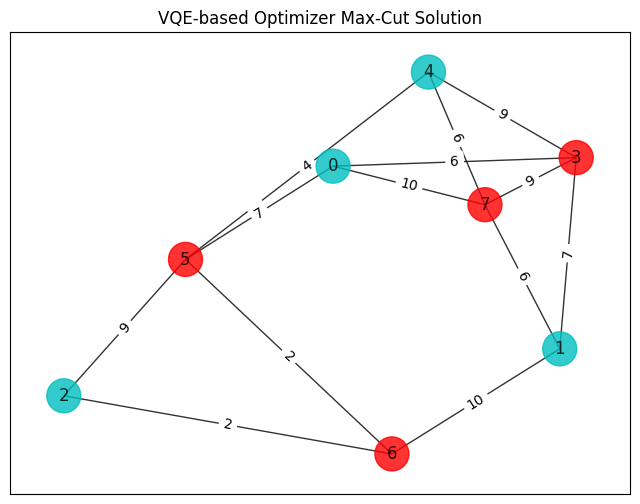

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import warnings

# Suppress specific deprecation warnings from Qiskit
warnings.filterwarnings("ignore", category=DeprecationWarning, module='qiskit.primitives')
warnings.filterwarnings("ignore", message="The function ``qiskit.primitives.utils.init_observable()`` is deprecated")

# Function to generate a random weighted graph
def generate_random_graph(n, p):
    """Generates an Erdős-Rényi random graph with n nodes and edge probability p.

    Each edge is assigned a random weight between 1 and 10.
    """
    G = nx.erdos_renyi_graph(n, p)
    for (u, v) in G.edges():
        G[u][v]["weight"] = np.random.randint(1, 11)  # Random weights between 1 and 10
    return G

# Function to compute the weight matrix from the generated graph
def compute_weight_matrix(G):
    """Extracts the weight matrix from the given graph G.

    The weight matrix represents the weights of edges between each pair of nodes.
    """
    n = len(G.nodes())
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
    return w

# Function to draw the graph with specified node colors
def draw_graph(G, colors, pos):
    """Draws the weighted graph G using the provided node colors and positions.

    Node colors represent different sets or partitions in the Max-Cut solution.
    """
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Function to solve the Max-Cut problem using classical optimization
def solve_max_cut_classically(max_cut, w):
    """Solves the Max-Cut problem using a classical solver.

    Converts the Max-Cut problem into a quadratic program and then into an Ising model.
    Uses an exact classical eigensolver to find the optimal solution.
    """
    qp = max_cut.to_quadratic_program()
    #print("Quadratic Program:")
    #print(qp.prettyprint())

    # Convert the problem into an Ising Hamiltonian for quantum computation
    qubitOp, offset = qp.to_ising()
    #print("\nOffset:", offset)
    #print("Ising Hamiltonian:")
    #print(str(qubitOp))

    # Solve using the exact classical eigensolver
    exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = exact_solver.solve(qp)
    #print("\nExact Classical Solution:")
    #print(result.prettyprint())

    return qubitOp, offset, qp, result

# Function to solve the Max-Cut problem using VQE (Variational Quantum Eigensolver)
def solve_max_cut_vqe(qubitOp, offset, max_cut, qp, optimizer_reps=10, max_iter=500):
    """Solves the Max-Cut problem using the VQE algorithm.

    Uses a quantum variational form (ansatz) with SPSA optimization to approximate the solution.
    """
    # Define the variational form and optimizer for VQE
    optimizer = SPSA(maxiter=max_iter)
    ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=optimizer_reps, entanglement="full")

    # Construct the VQE solver with a quantum sampler
    vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

    # Run VQE to find the minimum eigenvalue of the Ising Hamiltonian
    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp)
    x_vqe = max_cut.sample_most_likely(vqe_result.eigenstate)

    print("\nVQE Energy:", vqe_result.eigenvalue.real)
    print("VQE Max-Cut Objective:", vqe_result.eigenvalue.real + offset)
    print("VQE Solution:", x_vqe)
    print("VQE Solution Objective:", qp.objective.evaluate(x_vqe))

    return vqe, x_vqe, vqe_result

# Function to visualize the Max-Cut solution on the graph
def visualize_solution(G, solution, pos, title):
    """Visualizes the Max-Cut solution on the graph G.

    Colors nodes based on their assignment in the solution and displays the graph.
    """
    n = len(G.nodes())
    # Pad the solution with zeros if it's shorter than the number of nodes
    padded_solution = np.pad(solution, (0, max(0, n - len(solution))), mode='constant', constant_values=0)
    colors = ["r" if padded_solution[i] == 0 else "c" for i in range(n)]
    plt.figure(figsize=(8, 6))
    draw_graph(G, colors, pos)
    plt.title(title)
    plt.show()

# Main function to run the entire Max-Cut problem-solving process
def main():
    # Parameters for generating the graph and running the VQE
    n = 8  # Number of nodes in the graph
    p = 0.4  # Probability for edge creation in the Erdős-Rényi model
    optimizer_reps = 10
    max_iter = 500

    # Generate a random weighted graph and draw it
    G = generate_random_graph(n, p)
    pos = nx.spring_layout(G, seed=42)  # Consistent layout for visualization
    colors = ["r" for node in G.nodes()]
    #draw_graph(G, colors, pos)

    # Compute the weight matrix from the graph
    w = compute_weight_matrix(G)

    # Define the Max-Cut problem from the weight matrix
    max_cut = Maxcut(w)

    # Solve the Max-Cut problem using a classical optimizer
    qubitOp, offset, qp, classical_result = solve_max_cut_classically(max_cut, w)
    classical_solution = max_cut.sample_most_likely(classical_result.x)
    #visualize_solution(G, classical_solution, pos, "Classical Max-Cut Solution")

    # Solve the Max-Cut problem using VQE
    vqe, x_vqe, vqe_result = solve_max_cut_vqe(qubitOp, offset, max_cut, qp, optimizer_reps, max_iter)
    #visualize_solution(G, x_vqe, pos, "VQE Max-Cut Solution")

    # Use the VQE-based optimizer to solve the quadratic program
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    vqe_result_optimizer = vqe_optimizer.solve(qp)
    print("\nVQE-based Optimizer Solution:")
    print(vqe_result_optimizer.prettyprint())

    # Visualize the solution found by the VQE-based optimizer
    visualize_solution(G, vqe_result_optimizer.x, pos, "VQE-based Optimizer Max-Cut Solution")

# Run the main function when the script is executed
if __name__ == "__main__":
    main()